In [87]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import os
import numpy as np
import scanpy as sc
import PyWGCNA
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import mannwhitneyu, false_discovery_control
import re
from itertools import combinations
from scipy.stats import pearsonr
from matplotlib import patches
import ast

In [88]:
def stack_triangle(df, col):
    df = pd.DataFrame(
        df.where(
            np.tri(
                df.shape[0],
                dtype=bool,
                k=-1
            ),
            np.nan
        ).stack(dropna=True), columns=[col] 
    )
    
    return df


In [89]:
# Function that generates and saves the ROC curve
def generate_roc_curve(
    data,
    target_col,
    feature_col,
):
    # ROC curve using all gene pairs
    fpr, tpr, thr = roc_curve(data[target_col], data[feature_col])
    auroc = roc_auc_score(data[target_col], data[feature_col])
    
    return fpr, tpr, thr, auroc

In [90]:
def fig_to_panels(fig, axes, output_dir):
    # Save individual panels of a figure 
    
    for panel_name, ax in axes.items():
        # Extract the panel title
        panel_title = ax.get_title()

        # Sanitize the panel title to use in filenames
        safe_title = panel_title.replace(" ", "_").replace("/", "_").replace("\n", "_").lower()

        # Create the filename for the current panel
        output_file = os.path.join(output_dir,safe_title)

        # Adjust the bounding box to include everything (labels, titles, etc.)
        extent = ax.get_tightbbox(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())

        # Save the individual panel using the adjusted bounding box
        fig.savefig(output_file + '.pdf', bbox_inches=extent, dpi=300)
        fig.savefig(output_file + '.png', bbox_inches=extent)

        print(f"Saved panel '{panel_title}' to {output_file}")


In [91]:
# Define colors
# Light version is obtained by setting alpha=0.5

ncolor  = '#00728eff' # solid dark
ncolor2 = '#00728e80' # alpha=0.5
lightncolor = '#7fb8c6ff' # solid light

tcolor  = '#ab3502ff'
tcolor2 = '#ab350280'
lighttcolor = '#d49980ff'

graycolor = '#4D4E4FFF'
graycolor2 ='#4d4e4f80'

lightgray = '#C8CAD4'

orangecolor = '#e69426'
orangecolor2 = '#e6942680'
lightorangecolor = '#f2c992ff'

In [92]:
def network_to_adj(network_path):
    network = pd.read_csv(
        network_path,
        usecols=['complex1', 'complex2', 'adj']
    )

    # Add a mirrored version of the network to make it symmetric
    network_mirrored = network.copy()
    network_mirrored.columns = ['complex2', 'complex1', 'adj']
    network = pd.concat([network, network_mirrored], ignore_index=True)

    adj = network.pivot(index='complex1', columns='complex2', values='adj').fillna(0)
    return adj

# Immunotherapy Prediction

In [93]:
## Read the results
cohorts_dir = '/home/lnemati/pathway_crosstalk/results/immunotherapy/features_sets/tissues'

dfs = []

for cohort in os.listdir(cohorts_dir):
    path = os.path.join(cohorts_dir, cohort, 'metrics')
    for file in os.listdir(path):
        metricsdf = pd.read_csv(os.path.join(path, file))
        metricsdf.columns = ['type'] + list(metricsdf.columns[1:])
        metricsdf['cohort'] = cohort
        
        probs_path = os.path.join(cohorts_dir, cohort, 'prediction_probabilities')
        probs = pd.read_csv(os.path.join(probs_path, 'whole_transcriptome.csv'), index_col=0)
        metricsdf['n_patients'] = probs.shape[1]
        
        dfs.append(metricsdf)
        
metricsdf = pd.concat(dfs, ignore_index=True)

In [94]:
import os
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

cohorts_dir = '/home/lnemati/pathway_crosstalk/results/immunotherapy/features_sets/tissues'

roc_curves = {}
pr_curves = {}

for cohort in os.listdir(cohorts_dir):
    path = os.path.join(cohorts_dir, cohort, 'prediction_probabilities')
    
    roc_curves[cohort] = {}
    pr_curves[cohort] = {}

    for file in os.listdir(path):
        ftype = file.replace('.csv', '')
        roc_curves[cohort][ftype] = {}
        pr_curves[cohort][ftype] = {}

        tmp = pd.read_csv(os.path.join(path, file), index_col=0)

        # Convert true labels to binary (1 for 'R', 0 for 'N')
        y_true = tmp.iloc[0].map({'R': 1, 'N': 0}).values  
        y_score = tmp.iloc[1].astype(float).values  # Ensure probabilities are floats

        # Compute ROC Curve
        fpr, tpr, roc_thresholds = roc_curve(y_true, y_score)
        roc_curves[cohort][ftype]['fpr'] = fpr
        roc_curves[cohort][ftype]['tpr'] = tpr
        roc_curves[cohort][ftype]['thresholds'] = roc_thresholds
        roc_curves[cohort][ftype]['auc'] = roc_auc_score(y_true, y_score)

        # Compute Precision-Recall Curve
        precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)
        pr_curves[cohort][ftype]['precision'] = precision
        pr_curves[cohort][ftype]['recall'] = recall
        pr_curves[cohort][ftype]['thresholds'] = pr_thresholds
        pr_curves[cohort][ftype]['auprc'] = average_precision_score(y_true, y_score)


In [95]:
order_labels_dict = {
    'cd274': 'CD274',
    'tls-melanoma': 'TLS-Melanoma',
    'caf_pca': 'CAF (PCA)',
    't_cell_dysfunction_pca': 'T Cell Dysfunction (PCA)',
    'mdsc_pca': 'MDSC (PCA)',
    'ifng': 'IFNG',
    'tam_m2_pca': 'TAM M2 (PCA)',
    'cd8': 'CD8',
    'whole_transcriptome': 'All Genes (PCA)',
    't_cell_exclusion_pca': 'T Cell Exclusion (PCA)',
    'all_ccis': 'All CCIs (PCA)',
    #'all_signatures': 'All Signatures',
    'tls': 'TLS',
    't_cell-inflamed_gep': 'T Cell-Inflamed GEP',
    #'all_motifs': 'All Motifs',
    'all_cliques': 'Cliques'
}

order = []
features_labels = []

baseline = metricsdf.query('type == "whole_transcriptome" and cohort != "full_dataset"')['auroc'].mean()

for idx in metricsdf.groupby('type')['auroc'].mean().sort_values().index:
    if metricsdf.query('type == @idx and cohort != "full_dataset"')['auroc'].mean() >= baseline:
        if idx in order_labels_dict.keys():
            order.append(idx)
            features_labels.append(order_labels_dict[idx])

#for idx in metricsdf.query('cohort != "full_dataset"').groupby('type')['auroc'].median().sort_values().index:
#    if idx in order_labels_dict.keys():
#        order.append(idx)
#        features_labels.append(order_labels_dict[idx])

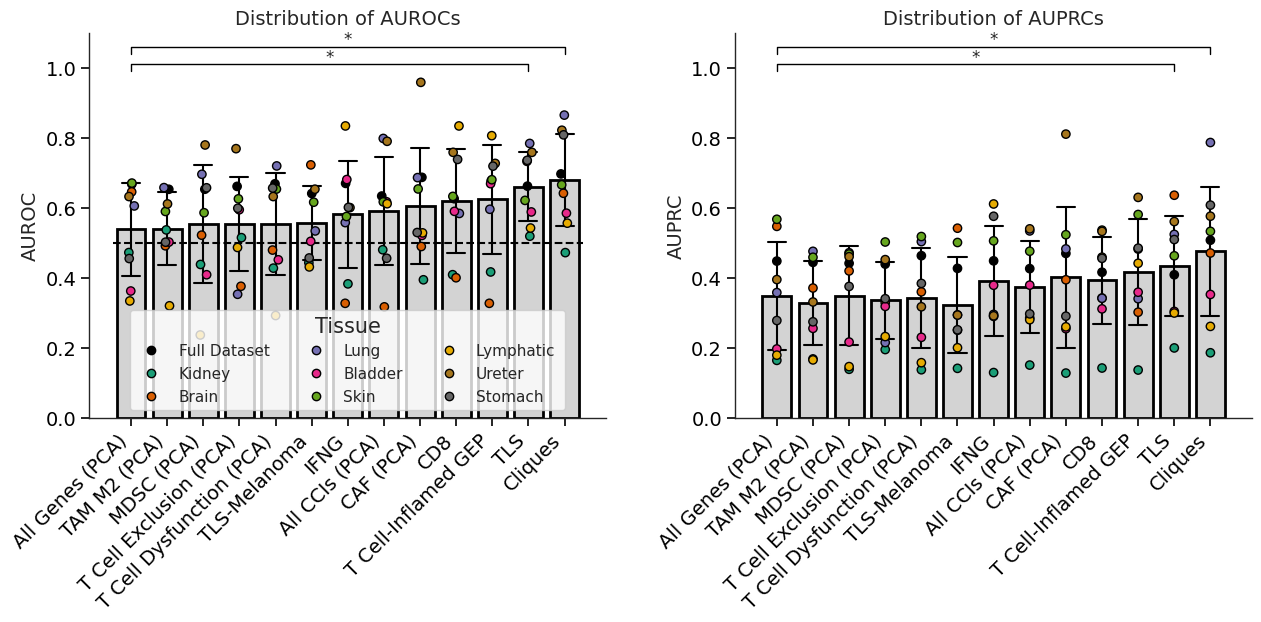

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

fs = 14  # Font size
smallfs = 11

# Compute differences
def compute_differences(df):
    df = df.copy()
    whole_transcriptome_values = df[df["type"] == "whole_transcriptome"].set_index("cohort")["auroc"]
    df["auroc_diff"] = df.apply(lambda row: row["auroc"] - whole_transcriptome_values[row["cohort"]], axis=1)
    whole_transcriptome_values = df[df["type"] == "whole_transcriptome"].set_index("cohort")["auprc"]
    df["auprc_diff"] = df.apply(lambda row: row["auprc"] - whole_transcriptome_values[row["cohort"]], axis=1)
    return df

df_diff = compute_differences(metricsdf)

# Setup figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
plt.subplots_adjust(wspace=0.25)

# Get unique cohorts excluding full_dataset
cohorts = [c for c in df_diff.cohort.unique() if c != "full_dataset"]
colors = sns.color_palette("Dark2", len(cohorts))
cohort_colors = dict(zip(cohorts, colors))
cohort_colors['full_dataset'] = 'black'

# AUROC subplot (Left)
ax1 = axes[0]
#sns.boxplot(df.query('cohort != "full_dataset"'), x='type', y='auroc', color='lightgray', boxprops={"alpha": 0.7}, ax=ax1, order=order)

sns.barplot(
    data=metricsdf,
    x='type',
    y='auroc',
    estimator='mean',
    ci='sd',
    color='lightgray',
    ax=ax1,
    order=order,
    errcolor='black',
    errwidth=1.5,
    capsize=0.5,
    lw=2,
    edgecolor='k',
)
sns.stripplot(metricsdf, x='type', y='auroc', hue='cohort', palette=cohort_colors, jitter=True, size=6, edgecolor="black", linewidth=1., ax=ax1, order=order)

ax1.hlines(0.5, *ax1.get_xlim(), color='k', linestyle='--')
#ax1.set_title("AUROC", fontsize=fs)
ax1.set_xlabel("Features Set", fontsize=fs)
ax1.set_ylabel("AUROC", fontsize=fs)
ax1.set_title('Distribution of AUROCs', fontsize=fs)


# AUPRC subplot (Right)
ax2 = axes[1]
#sns.boxplot(metricsdf.query('cohort != "full_dataset"'), x='type', y='auprc', color='lightgray', boxprops={"alpha": 0.7}, ax=ax2, order=order)

sns.barplot(
    data=metricsdf,
    x='type',
    y='auprc',
    estimator='mean',
    ci='sd',
    color='lightgray',
    ax=ax2,
    order=order,
    errcolor='black',
    errwidth=1.5,
    capsize=0.5,
    lw=2,
    edgecolor='k',
)
sns.stripplot(metricsdf, x='type', y='auprc', hue='cohort', palette=cohort_colors, jitter=False, size=6, edgecolor="black", linewidth=1., ax=ax2, order=order)

#ax2.set_title("AUPRC", fontsize=fs)
ax2.set_xlabel("Features Set", fontsize=fs)
ax2.set_ylabel("AUPRC", fontsize=fs)
ax2.set_title('Distribution of AUPRCs', fontsize=fs)

ax2.get_legend().remove()

#fig.suptitle('Distribution of AUROCs and AUPRCs Across Features Sets', fontsize=fs, )

# Compute p-values for AUROC and AUPRC separately
p_values_auroc = []
p_values_auprc = []
comparisons = []
reference_group = "whole_transcriptome"

for group in order:
    if group == reference_group:
        continue
    stat_auroc, p_auroc = wilcoxon(df_diff.query(f'type == "{group}"')["auroc_diff"], alternative='greater')
    stat_auprc, p_auprc = wilcoxon(df_diff.query(f'type == "{group}"')["auprc_diff"], alternative='greater')
    
    if p_auroc < 0.05 or p_auprc < 0.05:
        p_values_auroc.append(p_auroc)
        p_values_auprc.append(p_auprc)
        comparisons.append(group)

# Function to convert p-values to significance stars
def get_significance_label(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

pval_labels_auroc = {group: get_significance_label(p) for group, p in zip(comparisons, p_values_auroc)}
pval_labels_auprc = {group: get_significance_label(p) for group, p in zip(comparisons, p_values_auprc)}

ax1.set_ylim(bottom=0, top=1.1)
ax2.set_ylim(bottom=0, top=1.1)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

# Function to add significance bars
def add_significance_bars(ax, pval_labels, comparisons, y_offset=0.05, text_offset=0.02):
    y_max = 0.9*ax.get_ylim()[1]
    bar_height = (y_max - ax.get_ylim()[0]) * 0.02
    
    for i, group in enumerate(comparisons):
        sig_label = pval_labels[group]
        x1, x2 = order.index(reference_group), order.index(group)
        y = y_max + (2.5 * i * bar_height)

        ax.plot([x1, x1, x2, x2], [y, y + bar_height, y + bar_height, y], lw=1, linestyle='-', color="black")
        ax.text(0.5 * (x1 + x2), y + 1.3 * bar_height, sig_label, ha='center', fontsize=12)

# Add significance bars
add_significance_bars(ax1, pval_labels_auroc, comparisons)
add_significance_bars(ax2, pval_labels_auprc, comparisons)

# Adjust x-labels
for ax in axes:
    ax.set_xticklabels(features_labels, rotation=45, ha='right')
    ax.set_xlabel('')
    ax.tick_params(labelsize=fs)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

handles, legend_labels = ax1.get_legend_handles_labels()
ax1.legend(
    handles,
    [label.title().replace('_', ' ').replace('Tissue', '') for label in legend_labels],
    title="Tissue",
    ncol=3,
    fontsize=smallfs,
    loc='lower center'
)

for ax in (ax1, ax2):
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    
    ax.tick_params(
        axis='both',
        which='both',
        labelsize=fs,
        direction='out',
        length=6,
        width=1.2,
        colors='black'
    )
    
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/auroc_auprc_barplot.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/auroc_auprc_barplot.png', bbox_inches='tight', dpi=300)

plt.show()

In [104]:
metricsdf.query('type == "all_cliques"').sort_values('auroc', ascending=False)

type     auroc     auprc            cohort  n_patients
42   all_cliques  0.864286  0.785983              lung          47
98   all_cliques  0.821053  0.575490            ureter          24
112  all_cliques  0.807853  0.607107           stomach          78
0    all_cliques  0.696257  0.506933      full_dataset        1246
70   all_cliques  0.665174  0.532180              skin         474
28   all_cliques  0.640974  0.470306             brain          46
56   all_cliques  0.584091  0.351844           bladder         174
84   all_cliques  0.555556  0.260633  lymphatic_tissue          22
14   all_cliques  0.471392  0.185279            kidney         341

In [98]:
p_values_auroc

[0.013671875, 0.02734375]

In [99]:
p_values_auprc

[0.02734375, 0.02734375]

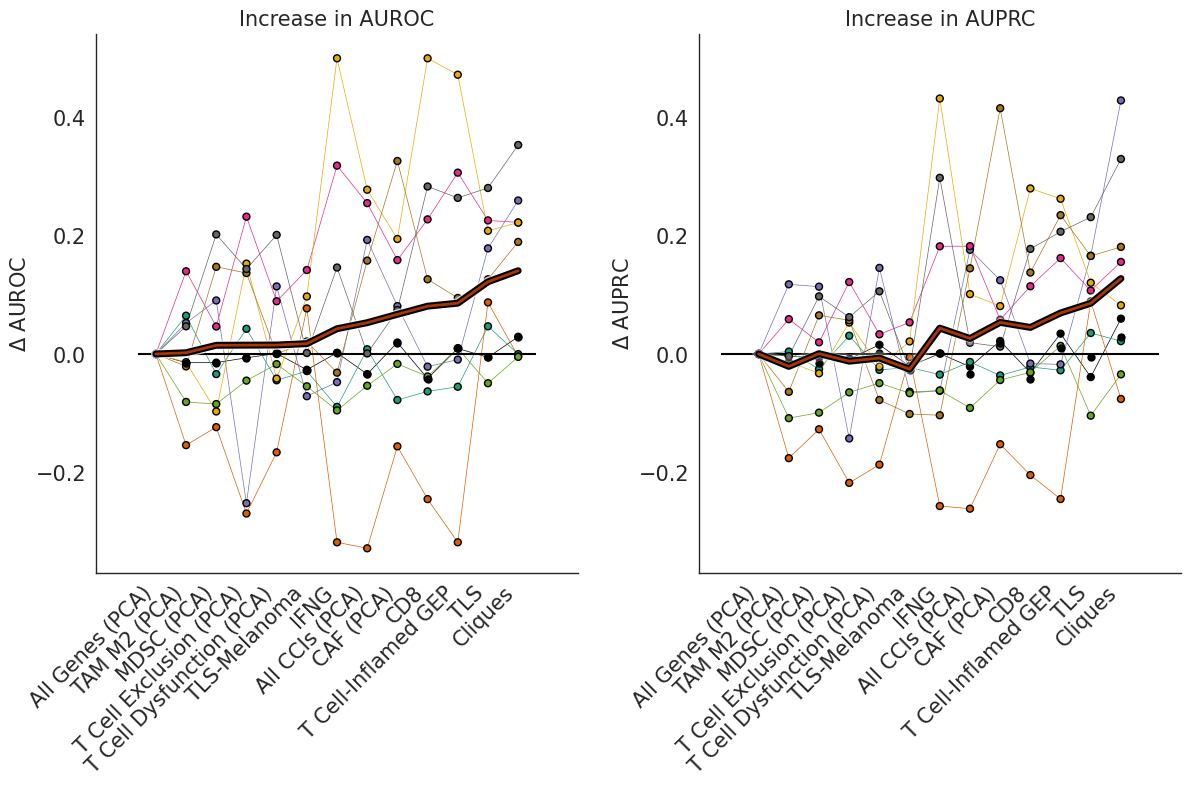

In [12]:
import matplotlib.patheffects as pe

# Setup figure with only two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True)
plt.subplots_adjust(wspace=0.25)
fs = 15  # Font size
alpha=1

ax3, ax4 = axes  # Assign the two axes

# AUROC Difference subplot (Left)
sns.stripplot(df_diff, x='type', y='auroc_diff', hue=df_diff['cohort'], palette=cohort_colors, 
              jitter=False, size=5, edgecolor="black", linewidth=1., alpha=alpha, ax=ax3, order=order)
sns.stripplot(df_diff.query('cohort == "full_dataset"'), x='type', y='auroc_diff', color='black', 
              jitter=False, size=5, edgecolor="black", linewidth=1., alpha=alpha, ax=ax3, order=order)

for cohort in df_diff.cohort.unique():
    ax3.plot(df_diff.query('cohort == @cohort').set_index('type').reindex(order)['auroc_diff'], 
             color=cohort_colors.get(cohort, 'black'), linestyle='-', alpha=alpha, lw=0.5)

# Mean AUROC difference line
mean_auroc = df_diff.groupby('type')['auroc_diff'].mean().reindex(order)

ax3.plot(
    order,
    mean_auroc,
    color=tcolor,  # This will stay fully visible
    linewidth=2,
    linestyle='-',
    path_effects=[
        pe.Stroke(linewidth=7, foreground='white', alpha=0.7),   # Outer soft white halo
        pe.Stroke(linewidth=5, foreground='black', alpha=1),     # Inner solid black halo
        pe.Normal()                                              # Actual line on top
    ],
    label='Mean',
    zorder=10
)

ax3.hlines(0, *ax3.get_xlim(), color='k', linestyle='-')
ax3.set_ylabel(r"$\Delta$ AUROC", fontsize=fs)

# AUPRC Difference subplot (Right)
sns.stripplot(df_diff, x='type', y='auprc_diff', hue=df_diff['cohort'], palette=cohort_colors, 
              jitter=False, size=5, edgecolor="black", linewidth=1., alpha=alpha, ax=ax4, order=order)
sns.stripplot(df_diff.query('cohort == "full_dataset"'), x='type', y='auroc_diff', color='black', 
              jitter=False, size=5, edgecolor="black", linewidth=1., alpha=alpha, ax=ax4, order=order)

for cohort in df_diff.cohort.unique():
    ax4.plot(df_diff.query('cohort == @cohort').set_index('type').reindex(order)['auprc_diff'], 
             color=cohort_colors.get(cohort, 'black'), alpha=alpha, linestyle='-', lw=0.5)

# Mean AUPRC difference line
mean_auprc = df_diff.groupby('type')['auprc_diff'].mean().reindex(order)
ax4.plot(
    order,
    mean_auprc,
    color=tcolor,  # This will stay fully visible
    linewidth=2,
    linestyle='-',
    path_effects=[
        pe.Stroke(linewidth=10, foreground='white', alpha=0.25),   # Outer soft white halo
        pe.Stroke(linewidth=6, foreground='white', alpha=0.5),   # Outer soft white halo
        pe.Stroke(linewidth=5, foreground='black', alpha=1),     # Inner solid black halo
        pe.Normal()                                              # Actual line on top
    ],
    label='Mean',
    zorder=10
)

ax4.hlines(0, *ax4.get_xlim(), color='k', linestyle='-')
ax4.set_ylabel(r"$\Delta$ AUPRC", fontsize=fs)

# Adjust x-labels
for ax in axes:
    ax.set_xticklabels(features_labels, rotation=45, ha='right')
    ax.set_xlabel('')
    ax.tick_params(labelsize=fs)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Make y-limits consistent for difference plots
min_ylim = min(ax3.get_ylim()[0], ax4.get_ylim()[0])
max_ylim = max(ax3.get_ylim()[1], ax4.get_ylim()[1])
ax3.set_ylim(min_ylim, max_ylim)
ax4.set_ylim(min_ylim, max_ylim)

#handles, legend_labels = ax3.get_legend_handles_labels()
#ax3.legend(handles, [label.title().replace('_', ' ').replace('Tissue', '') for label in legend_labels], 
#           title="Tissue", ncol=3, fontsize=12, loc='lower center')

# Remove auto-generated legend (from stripplots)
ax4.get_legend().remove()
ax3.get_legend().remove()

# Only keep the line labeled 'Mean'
#handles, labels_ = ax3.get_legend_handles_labels()
#mean_handles = [h for h, l in zip(handles, labels_) if l == 'Mean']
#ax3.legend(mean_handles, ['Mean'], loc='lower center', fontsize=12)

ax3.set_title('Increase in AUROC', fontsize=fs)
ax4.set_title('Increase in AUPRC', fontsize=fs)

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/tissue_difference_auroc_auprc_with_mean.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/tissue_difference_auroc_auprc_with_mean.png', bbox_inches='tight', dpi=300)

plt.show()


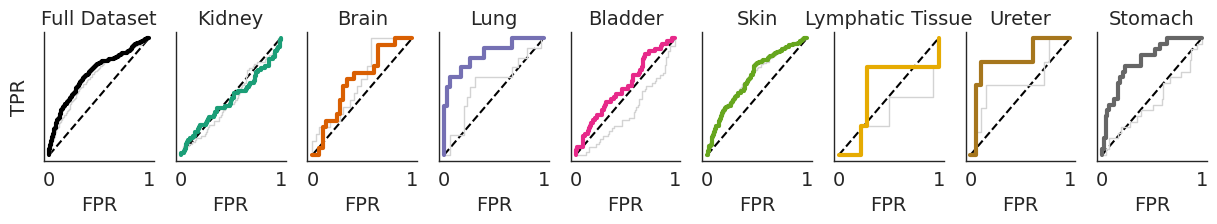

In [13]:
ftype = 'all_cliques'

fs = 14
N = len(roc_curves)
fig, axes = plt.subplots(1, N, figsize=(15, 15/N), sharey=True)

for i, cohort in enumerate(roc_curves.keys()):
    ax = axes[i]

    fpr_cliques = roc_curves[cohort]['all_cliques']['fpr']
    tpr_cliques = roc_curves[cohort]['all_cliques']['tpr']
    auc_cliques = roc_curves[cohort]['all_cliques']['auc']

    fpr_whole = roc_curves[cohort]['whole_transcriptome']['fpr']
    tpr_whole = roc_curves[cohort]['whole_transcriptome']['tpr']
    auc_whole = roc_curves[cohort]['whole_transcriptome']['auc']

    color = cohort_colors.get(cohort, 'black')
    title = cohort.replace('_', ' ').title()

    ax.set_title(f"{title}", fontsize=fs)
    ax.set_xlabel("FPR", fontsize=fs)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])

    if i == 0:
        ax.set_ylabel("TPR", fontsize=fs)
    else:
        ax.set_yticklabels([])  # Hide y-tick labels on other plots

    ax.plot([0, 1], [0, 1], color='k', linestyle="--", label="Random")
    ax.plot(fpr_cliques, tpr_cliques, label=f"{cohort} - {ftype} (AUC = {auc_cliques:.2f})", color=color, lw=3, zorder=10)
    ax.plot(fpr_whole, tpr_whole, label=f"{cohort} - Whole Transcriptome (AUC = {auc_whole:.2f})", color='lightgray', lw=1, zorder=5)

    ax.tick_params(axis='both', labelsize=fs)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()


In [14]:
## Read the results
parentdir = '/home/lnemati/pathway_crosstalk/results/immunotherapy/individual_interactions_and_motifs'

dfs = []

for tissue in os.listdir(parentdir):
    #if tissue in ['full_dataset']: # add back lymph and ureter when they finish running
    #    continue
    path = os.path.join(parentdir, tissue, 'aggregated', 'aggregated.csv')
    tissuedf = pd.read_csv(os.path.join(path))
    tissuedf = tissuedf.rename(columns={'Unnamed: 0': 'interaction'})
    #tissuedf['motif'] = tissuedf['motif'].replace({'3_clique': 'cliques', '4_clique': 'cliques'})

    dfs.append(tissuedf)
        
crosstalkdf = pd.concat(dfs, ignore_index=True)

In [15]:
## Read the results
parentdir = '/home/lnemati/pathway_crosstalk/results/immunotherapy/individual_interactions_and_motifs'

dfs = []

for tissue in os.listdir(parentdir):
    #if tissue in ['full_dataset']: # add back lymph and ureter when they finish running
    #    continue
    path = os.path.join(parentdir, tissue, 'aggregated', 'aggregated.csv')
    tissuedf = pd.read_csv(os.path.join(path))
    tissuedf = tissuedf.rename(columns={'Unnamed: 0': 'interaction'})
    #tissuedf['motif'] = tissuedf['motif'].replace({'3_clique': 'cliques', '4_clique': 'cliques'})

    dfs.append(tissuedf)
        
crosstalkdf = pd.concat(dfs, ignore_index=True)
#crosstalkdf = crosstalkdf.dropna()

crosstalkdf = crosstalkdf.sort_values(by='auroc')[::-1]

crosstalkdf = crosstalkdf.query('motif != "random_pairs"')
#crosstalkdf = crosstalkdf.query('tissue != "full_dataset"')

better = crosstalkdf.query('auroc > auroc1 and auroc > auroc2')
better = better.query('auprc > auprc1 and auprc > auprc2')

In [16]:
df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs_permutations.csv')
motifs = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/counts.csv', index_col='motif')
motifs = motifs['number'] 

df3 = df[[col for col in df.columns if col.startswith('3')]]
df4 = df[[col for col in df.columns if col.startswith('4')]]
motifs3 = motifs.loc[[idx for idx in motifs.index if idx.startswith('3')]]
motifs4 = motifs.loc[[idx for idx in motifs.index if idx.startswith('4')]]

motifs3 = motifs3 / motifs3.sum()
motifs4 = motifs4 / motifs4.sum()
df3 = (df3.T / df3.sum(1)).T
df4 = (df4.T / df4.sum(1)).T

df = df3.join(df4)
motifs = pd.concat([motifs3, motifs4])

means = df.mean()
stds = df.std()

motifs_z = ((motifs - means) / stds).sort_values()
motifs_z.name = 'z'

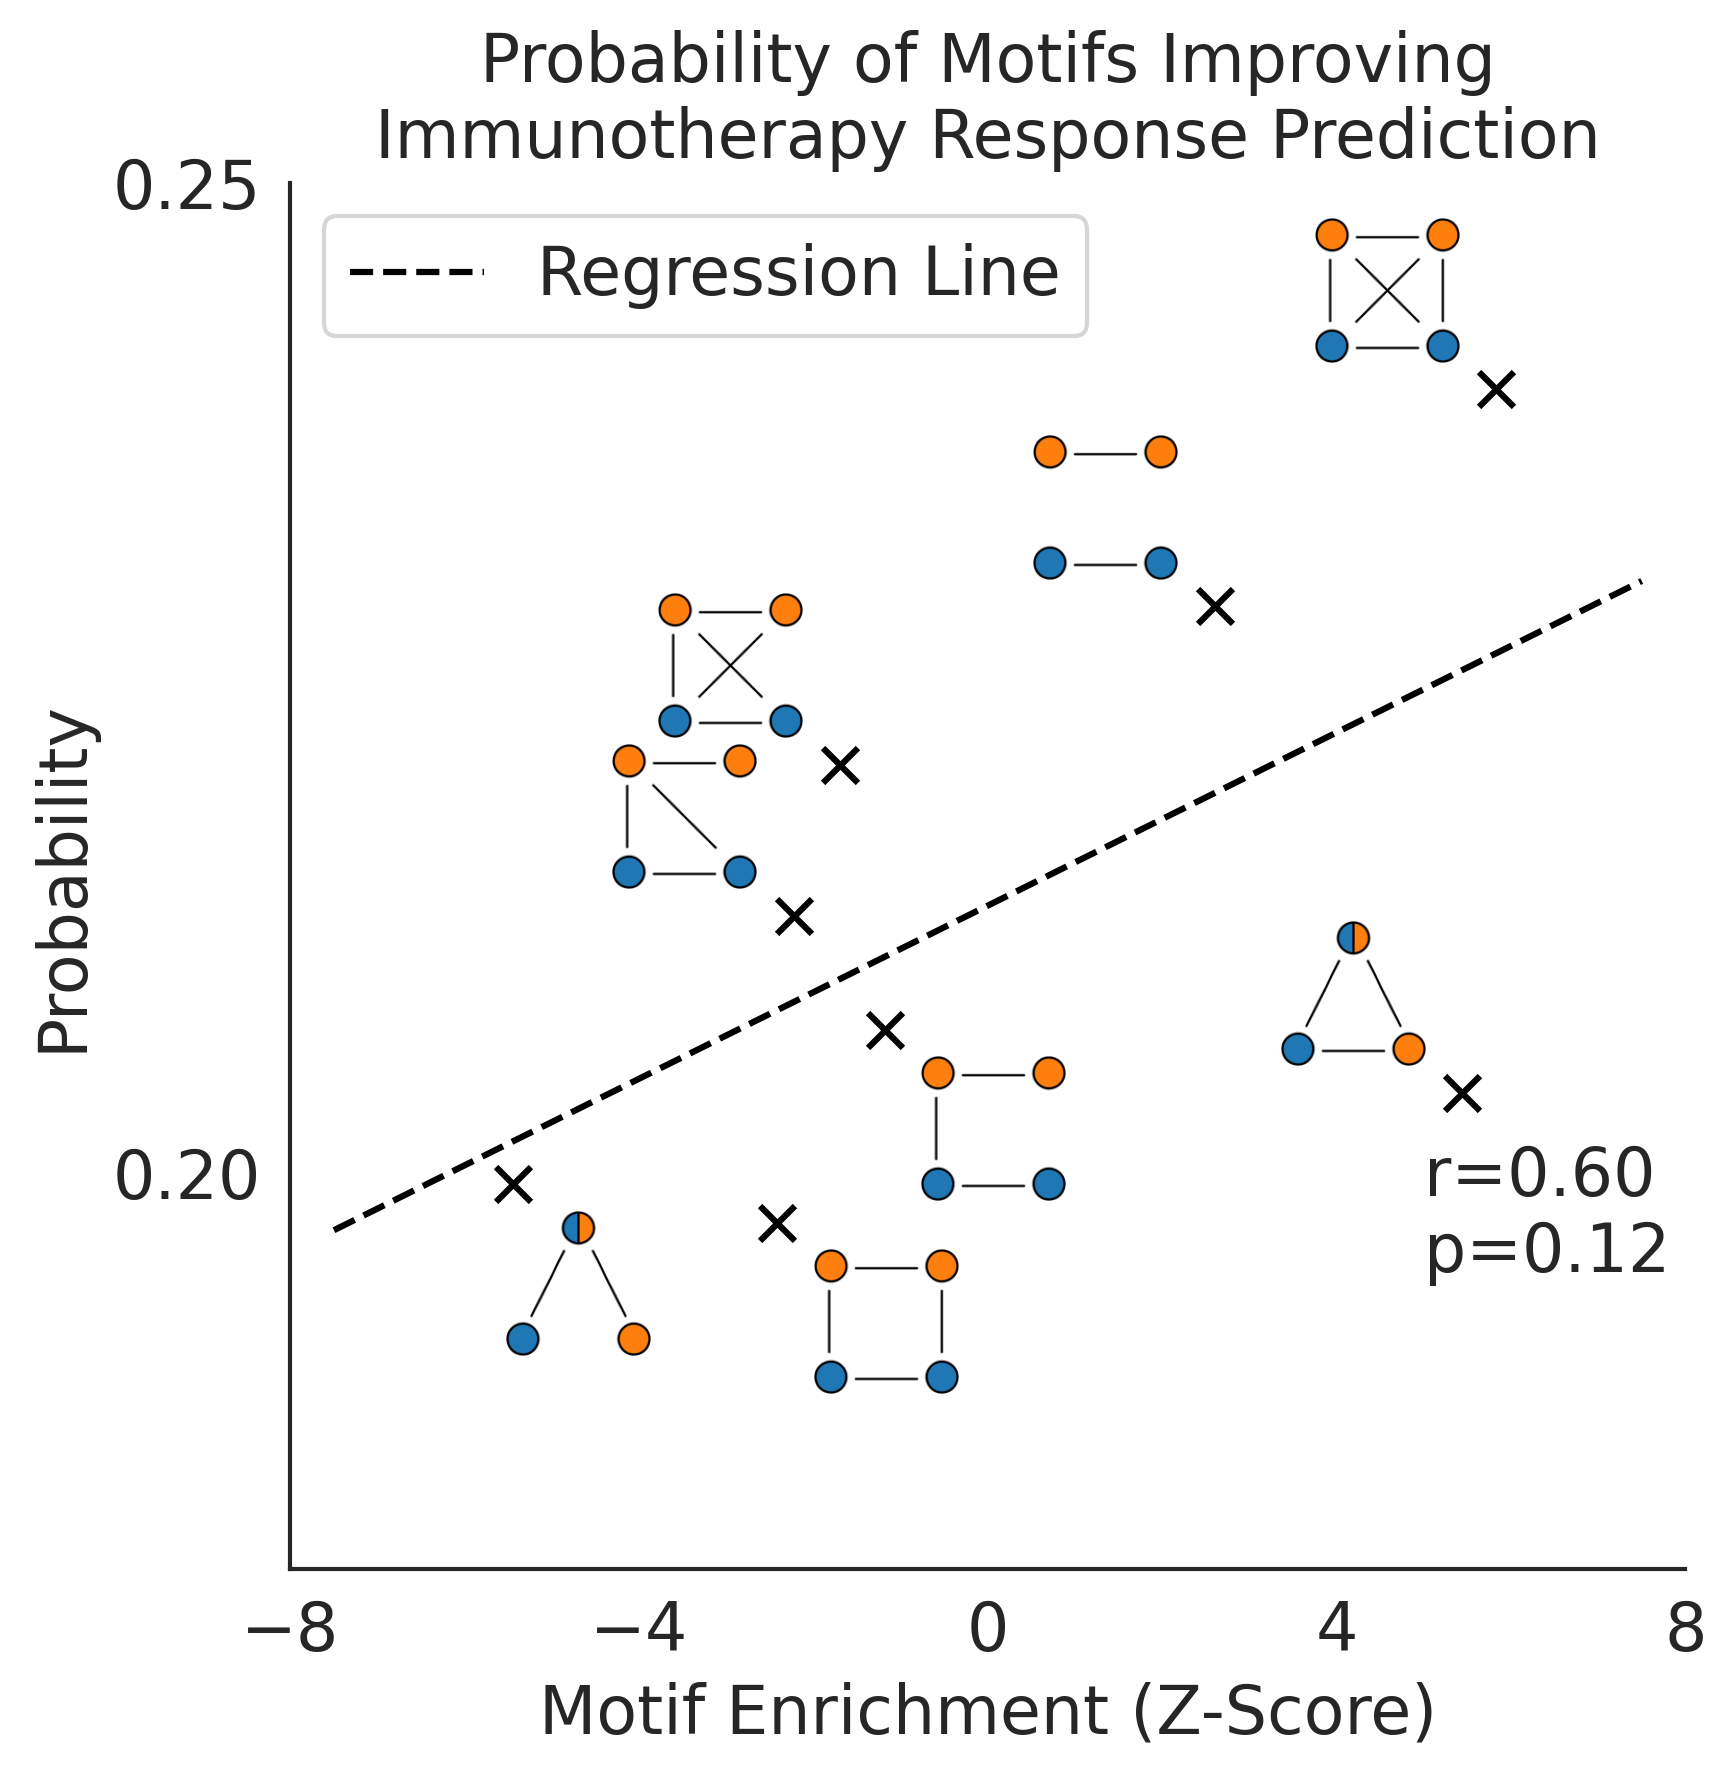

In [17]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import image as mpimg
import os
from PIL import Image

# Constants
dpi = 300
img_dir = '/home/lnemati/pathway_crosstalk/data/motifs_icons/'  # Update this path
image_scaling_factor = 0.25  # Adjust this factor to scale image size (smaller = more zoomed out)
x_offset = -1.25
y_offset = 0.005

fs = 16

# Filter data
#all_counts = crosstalkdf.query('tissue != "full_dataset"').motif.value_counts().sort_values(ascending=False)

probs = (better.query('tissue != "full_dataset"').motif.value_counts() / crosstalkdf.query('tissue != "full_dataset"').motif.value_counts()).sort_values()
#probs = (better.motif.value_counts() / crosstalkdf.motif.value_counts()).sort_values()
probs = probs.loc[motifs_z.index]

data = pd.DataFrame()
data['z'] = motifs_z
data['prob'] = probs

# Calculate Pearson correlation
r_value, p_value = pearsonr(probs, motifs_z)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=dpi)

# Plot the scatter points
#ax.scatter(
#    data['z'], 
#    data['prob'], 
#    color=lightgray, 
#    marker='s', 
#    edgecolors='black',  # Black edge color
#    s=70,
#    linewidths=1.5  # Thickness of the edge
#)
ax.scatter(
    data['z'], 
    data['prob'], 
    #color='black', 
    color='black', 
    marker='x', 
    edgecolors='black',  # Black edge color
    s=70,
    linewidths=1.5  # Thickness of the edge
)

# Add Pearson correlation to plot
ax.text(5, 0.195, 'r={:.2f}\np={:.2f}'.format(r_value, p_value), fontsize=fs)

# Set limits and ticks
ax.set_xlim(-8, 8)
ax.set_ylim(0.18, 0.25)
xticks = [-8, -4, 0, 4, 8]
yticks = [0.2, 0.25]
ax.set_xticks(xticks)
ax.set_yticks(yticks)

# Hide top and right spines
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)

# Add title and labels
ax.set_title('Probability of Motifs Improving\nImmunotherapy Response Prediction', fontsize=fs)
ax.set_xlabel('Motif Enrichment (Z-Score)', fontsize=fs)
ax.set_ylabel('Probability', fontsize=fs)

# Make the background of the plot transparent so the images can show up
ax.patch.set_alpha(0)

# Get the regression line parameters (slope and intercept)
slope, intercept = np.polyfit(data['z'], data['prob'], 1)

# Extend the regression line beyond the data range
x_extended = np.linspace(ax.get_xlim()[0] + 0.5, ax.get_xlim()[1] - 0.5, 100)
y_extended = slope * x_extended + intercept
ax.plot(x_extended, y_extended, linestyle='--', color='k', linewidth=1.5, label='Regression Line', zorder=-10)

# Dictionary to define manual positions for each motif
motif_positions = {
    '3_path': (data['z']['3_path']+2, data['prob']['3_path']-0.01),
    '4_cycle': (data['z']['4_cycle']+2.5, data['prob']['4_cycle']-0.01),
    '4_triangle_extra': (data['z']['4_triangle_extra'], data['prob']['4_triangle_extra']),
    '4_one_missing': (data['z']['4_one_missing'], data['prob']['4_one_missing']),
    '4_path': (data['z']['4_path']+2.5, data['prob']['4_path']-0.01),
    '4_no_crosstalk': (data['z']['4_no_crosstalk'], data['prob']['4_no_crosstalk']),
    '3_clique': (data['z']['3_clique'], data['prob']['3_clique']),
    '4_clique': (data['z']['4_clique'], data['prob']['4_clique']),
}

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

for motif, (x_pos, y_pos) in motif_positions.items():
    img_path = os.path.join(img_dir, f"{motif}.png")
    if os.path.exists(img_path):
        im = Image.open(img_path)
        im = im.resize((int(im.width * image_scaling_factor), int(im.height * image_scaling_factor)))
        imagebox = OffsetImage(im, zoom=image_scaling_factor, resample=True)
        ab = AnnotationBbox(imagebox, (x_pos + x_offset, y_pos + y_offset), frameon=False)
        ax.add_artist(ab)


# Hide legend, as it may conflict with the images
#plt.legend([], [], frameon=False)
plt.legend(fontsize=fs, loc='upper left')

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/motifs_z_prob.pdf', bbox_inches='tight', dpi=dpi)
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/motifs_z_prob.png', bbox_inches='tight', dpi=dpi)

# Show the plot
plt.show()


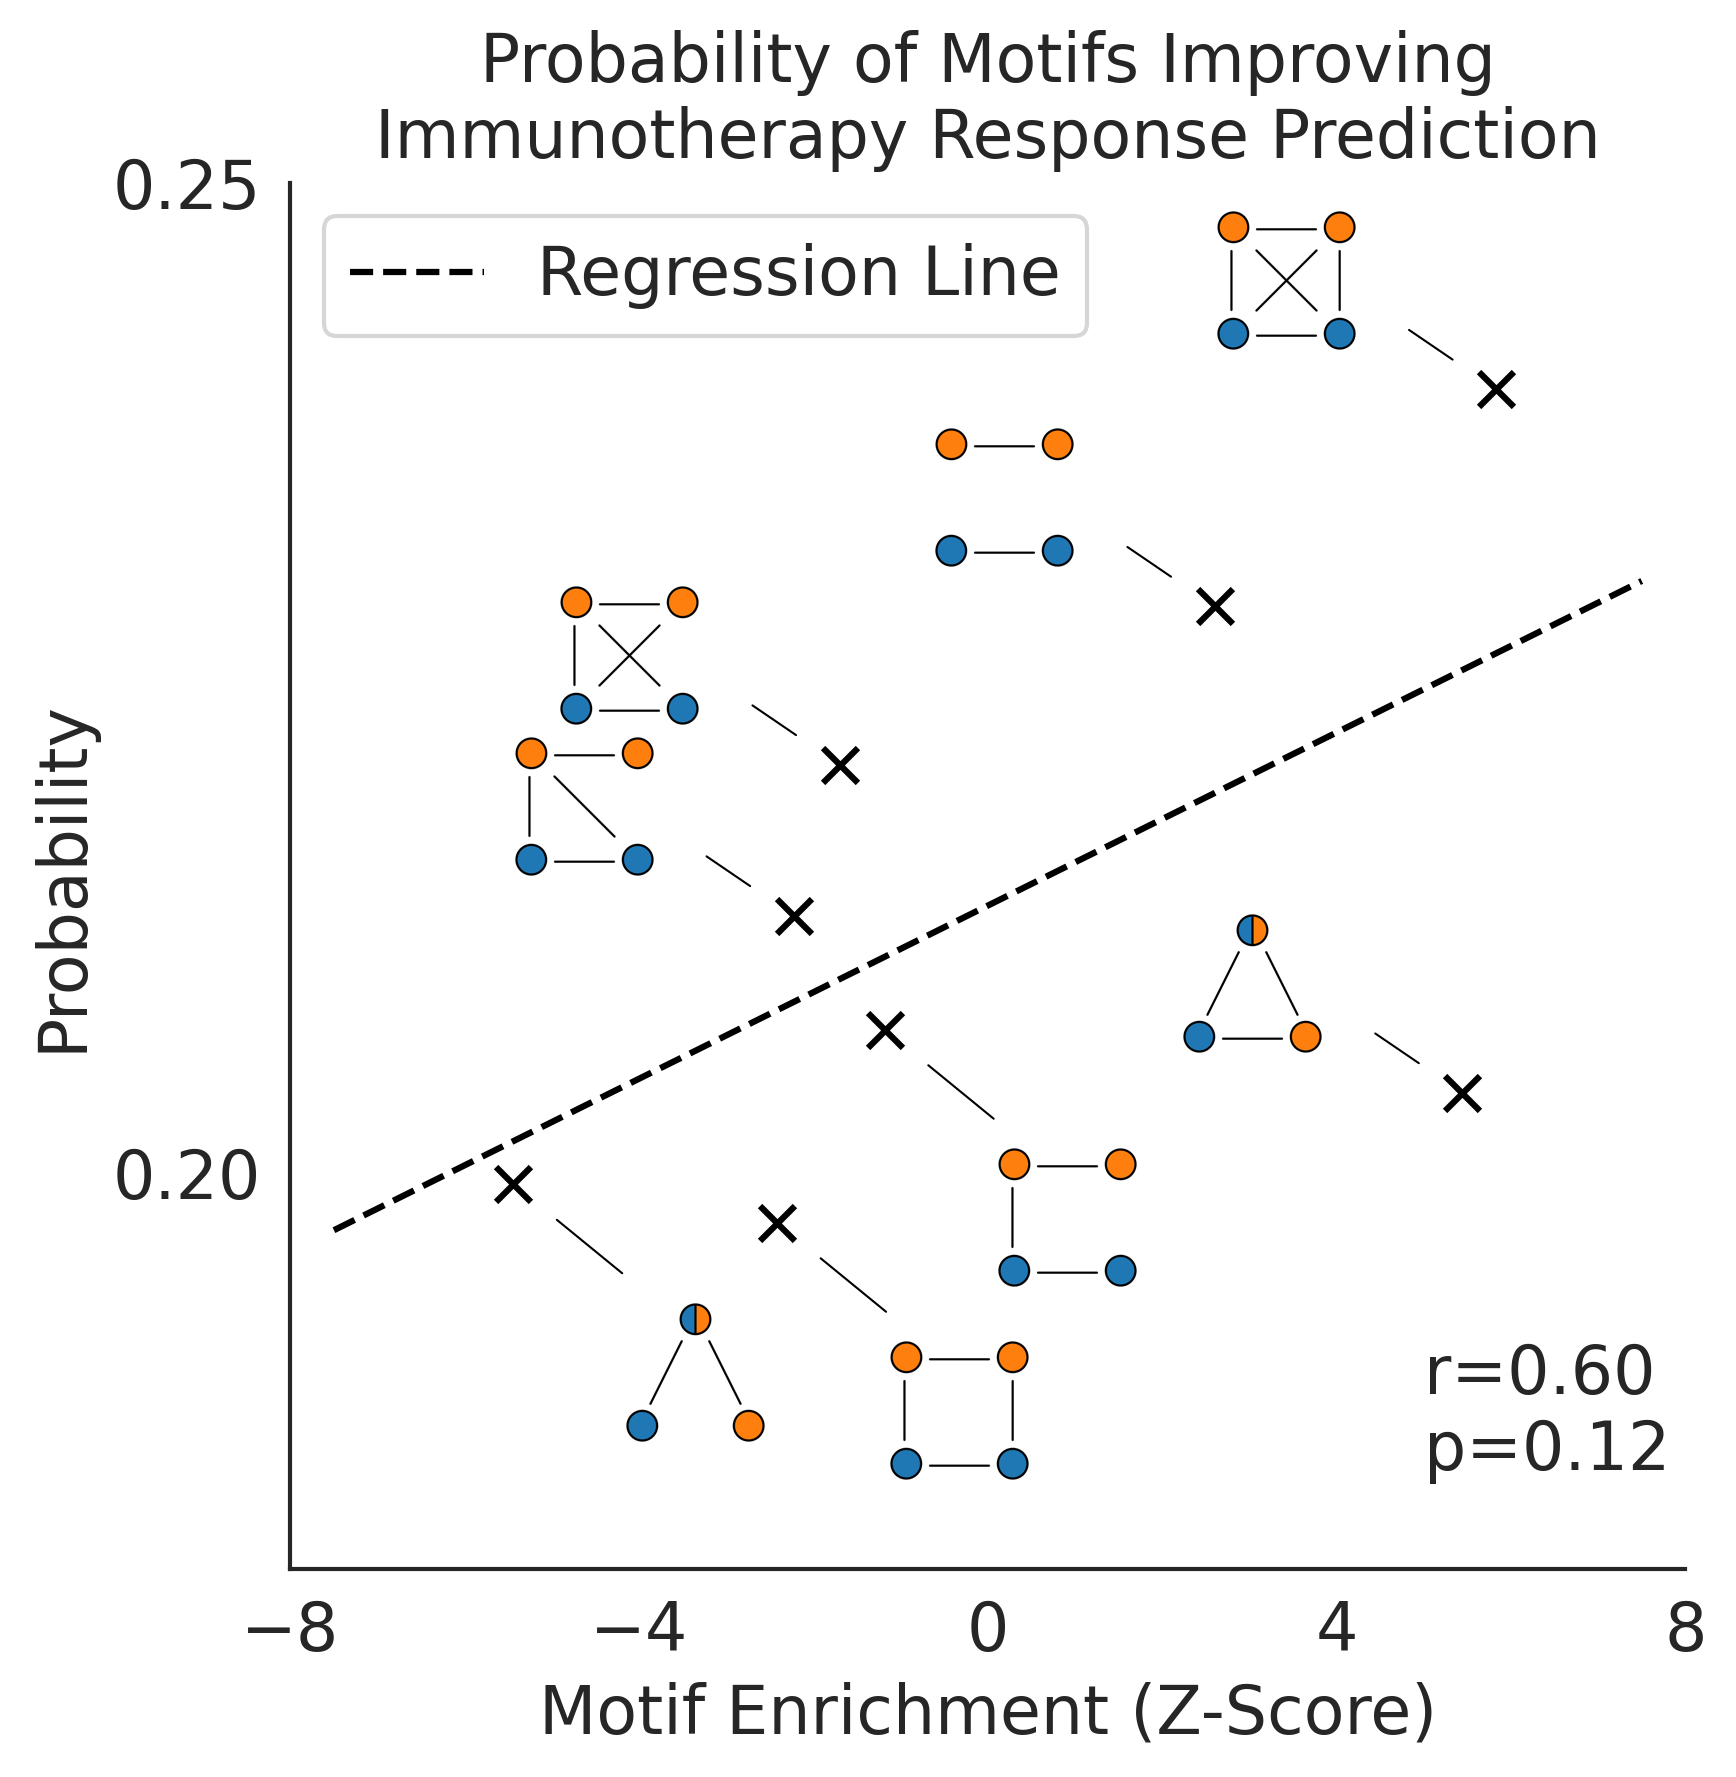

In [18]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from PIL import Image
import pandas as pd

# Constants
dpi = 300
img_dir = '/home/lnemati/pathway_crosstalk/data/motifs_icons/'
image_scaling_factor = 0.25
x_offset = 30  # in pixels
y_offset = 0.  # in data coordinates (converted later)
fs = 16

# Filter and prepare data
probs = (better.query('tissue != "full_dataset"').motif.value_counts() / 
         crosstalkdf.query('tissue != "full_dataset"').motif.value_counts()).sort_values()
probs = probs.loc[motifs_z.index]

data = pd.DataFrame({'z': motifs_z, 'prob': probs})

# Calculate Pearson correlation
r_value, p_value = pearsonr(probs, motifs_z)

# Create plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=dpi)

# Plot data points
ax.scatter(data['z'], data['prob'], color='black', marker='x', edgecolors='black', s=70, linewidths=1.5)

# Annotate with correlation
ax.text(5, 0.185, 'r={:.2f}\np={:.2f}'.format(r_value, p_value), fontsize=fs)

# Axes formatting
ax.set_xlim(-8, 8)
ax.set_ylim(0.18, 0.25)
ax.set_xticks([-8, -4, 0, 4, 8])
ax.set_yticks([0.2, 0.25])
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)
ax.set_title('Probability of Motifs Improving\nImmunotherapy Response Prediction', fontsize=fs)
ax.set_xlabel('Motif Enrichment (Z-Score)', fontsize=fs)
ax.set_ylabel('Probability', fontsize=fs)
ax.patch.set_alpha(0)  # Transparent background

# Regression line
slope, intercept = np.polyfit(data['z'], data['prob'], 1)
x_ext = np.linspace(ax.get_xlim()[0] + 0.5, ax.get_xlim()[1] - 0.5, 100)
y_ext = slope * x_ext + intercept
ax.plot(x_ext, y_ext, linestyle='--', color='k', linewidth=1.5, label='Regression Line', zorder=-10)

# Manual image positions
motif_positions = {
    '3_path': (data['z']['3_path']+2.5, data['prob']['3_path']-0.009),
    '4_cycle': (data['z']['4_cycle']+2.5, data['prob']['4_cycle']-0.009),
    '4_triangle_extra': (data['z']['4_triangle_extra']-2, data['prob']['4_triangle_extra']+0.006),
    '4_one_missing': (data['z']['4_one_missing']-2, data['prob']['4_one_missing']+0.006),
    '4_path': (data['z']['4_path']+2.5, data['prob']['4_path']-0.009),
    '4_no_crosstalk': (data['z']['4_no_crosstalk']-2, data['prob']['4_no_crosstalk']+0.006),
    '3_clique': (data['z']['3_clique']-2, data['prob']['3_clique']+0.006),
    '4_clique': (data['z']['4_clique']-2, data['prob']['4_clique']+0.006),
}

# Draw icons and connecting lines
for motif, (x_pos, y_pos) in motif_positions.items():
    img_path = os.path.join(img_dir, f"{motif}.png")
    if os.path.exists(img_path):
        im = Image.open(img_path)
        width, height = im.size
        im_resized = im.resize((int(width * image_scaling_factor), int(height * image_scaling_factor)))
        im_resized_np = np.array(im_resized)

        # Convert data coordinates to pixels
        pixel_pos = ax.transData.transform((x_pos, y_pos + y_offset))

        # Place image
        fig.figimage(
            im_resized_np,
            pixel_pos[0] - im_resized_np.shape[1] / 2 + x_offset,
            pixel_pos[1] - im_resized_np.shape[0] / 2,
            origin='upper'
        )

        # Draw line from marker to image
        line_frac = 0.5
        marker_trim = 0.5  # in data units

        # Get data position of marker and image
        x0, y0 = motifs_z.loc[motif], probs.loc[motif]
        x1, y1 = ax.transData.inverted().transform(pixel_pos)

        dx = x1 - x0
        dy = y1 - y0
        line_length = np.hypot(dx, dy)

        dxn, dyn = dx / line_length, dy / line_length
        x_start = x0 + dxn * marker_trim
        y_start = y0 + dyn * marker_trim
        x_end = x1 - dxn * (line_frac * line_length)
        y_end = y1 - dyn * (line_frac * line_length)

        ax.plot([x_start, x_end], [y_start, y_end], color='k', linewidth=0.5, zorder=-5)

# Optional: legend, save, show
plt.legend(fontsize=fs, loc='upper left')

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/motifs_z_prob.pdf', bbox_inches='tight', dpi=dpi)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/motifs_z_prob.png', bbox_inches='tight', dpi=dpi)

plt.show()


In [19]:
#crosstalkdf.to_csv('/home/lnemati/pathway_crosstalk/results/immunotherapy/aggregated/cliques_and_random_pairs.csv')
#crosstalkdf.query('motif == "cliques"').to_csv('/home/lnemati/pathway_crosstalk/results/immunotherapy/aggregated/cliques.csv')

In [20]:
## Read the results
parentdir = '/home/lnemati/pathway_crosstalk/results/immunotherapy/individual_interactions_and_motifs'

dfs = []

for tissue in os.listdir(parentdir):
    #if tissue in ['full_dataset']: # add back lymph and ureter when they finish running
    #    continue
    path = os.path.join(parentdir, tissue, 'aggregated', 'aggregated.csv')
    tissuedf = pd.read_csv(os.path.join(path))
    tissuedf = tissuedf.rename(columns={'Unnamed: 0': 'interaction'})
    #tissuedf['motif'] = tissuedf['motif'].replace({'3_clique': 'cliques', '4_clique': 'cliques'})

    dfs.append(tissuedf)
        
crosstalkdf = pd.concat(dfs, ignore_index=True)
crosstalkdf = crosstalkdf.dropna()

crosstalkdf = crosstalkdf.sort_values(by='auroc')[::-1]

#crosstalkdf = crosstalkdf.query('motif != "random_pairs"')
crosstalkdf = crosstalkdf.query('tissue != "full_dataset"')

better = crosstalkdf.query('auroc > auroc1 and auroc > auroc2')
better = better.query('auprc > auprc1 and auprc > auprc2')

In [21]:
# Assuming df is your dataframe
df_mean = crosstalkdf.groupby("interaction")[["auroc", "auroc_diff", "auprc", "auprc_diff"]].median().reset_index()
df_mean = df_mean.sort_values(by='auroc')[::-1]
df_mean.columns = ["interaction", "mean_auroc", "mean_auroc_diff", "mean_auprc", "mean_auprc_diff"]
# Create a mapping from interaction to motif
interaction_to_motif = crosstalkdf.drop_duplicates("interaction")[["interaction", "motif"]]

# Merge the motif info back to df_mean
df_mean = df_mean.merge(interaction_to_motif, on="interaction", how="left")

df_mean = df_mean.sort_values(by='mean_auroc')[::-1]
df_mean

#df_mean.to_csv('/home/lnemati/pathway_crosstalk/results/immunotherapy/aggregated/cliques_medians.csv')

interaction  mean_auroc  mean_auroc_diff  \
0               HLA-F+KIR3DS1&GDF15+TGFBR2    0.819444        -0.010526   
1                  CD4+HLA-DQB1&ACKR1+CCL5    0.736842         0.009190   
2              B4GALT3+P2RY14&CCL3L1+ACKR2    0.736111         0.000000   
3                  ACKR1+CXCL13&ACKR1+CCL5    0.732665        -0.009091   
4                   ACKR1+CXCL9&CD69+KLRB1    0.730828        -0.002041   
...                                    ...         ...              ...   
14701      WNT10A+FZD8_LRP5&WNT3+FZD1_LRP5    0.379017        -0.041249   
14702         ITGA2_ITGB1+LAMA5&DAG1+LAMA5    0.378565        -0.094448   
14703               TGM2+ADGRG1&FGF5+FGFR2    0.366370        -0.102196   
14704  DDC+HTR7&GAD2_SLC6A13+GABRA1_GABRB2    0.358831        -0.087774   
14705       GDF6+ACVR2B_BMPR1A&FGF20+FGFR2    0.324015        -0.132996   

       mean_auprc  mean_auprc_diff         motif  
0        0.415476        -0.024738  random_pairs  
1        0.428187         0.039016      4_clique  
2        0.494298         0.000000  random_pairs  
3        0.427959        -0.005230      3_clique  
4        0.452433         0.009255      4_clique  
...           ...              ...           ...  
14701    0.211910        -0.023634  random_pairs  
14702    0.228983        -0.037806      3_clique  
14703    0.239037        -0.038850  random_pairs  
14704    0.260632        -0.053538  random_pairs  
14705    0.196636        -0.042454  random_pairs  

[14706 rows x 6 columns]

In [22]:
crosstalkdf['motif'] = crosstalkdf.motif.replace({
    '3_clique': 'Cliques',
    '4_clique': 'Cliques',
    'random_pairs': 'Random Pairs',
    '4_cycle': 'Other Motifs',
    '4_path': 'Other Motifs',
    '4_triangle_extra': 'Other Motifs',
    '4_no_crosstalk': 'Other Motifs',
    '4_one_missing': 'Other Motifs',
    '3_path': 'Other Motifs',
})

df_mean['motif'] = df_mean.motif.replace({
    '3_clique': 'Cliques',
    '4_clique': 'Cliques',
    'random_pairs': 'Random Pairs',
    '4_cycle': 'Other Motifs',
    '4_path': 'Other Motifs',
    '4_triangle_extra': 'Other Motifs',
    '4_no_crosstalk': 'Other Motifs',
    '4_one_missing': 'Other Motifs',
    '3_path': 'Other Motifs',
})

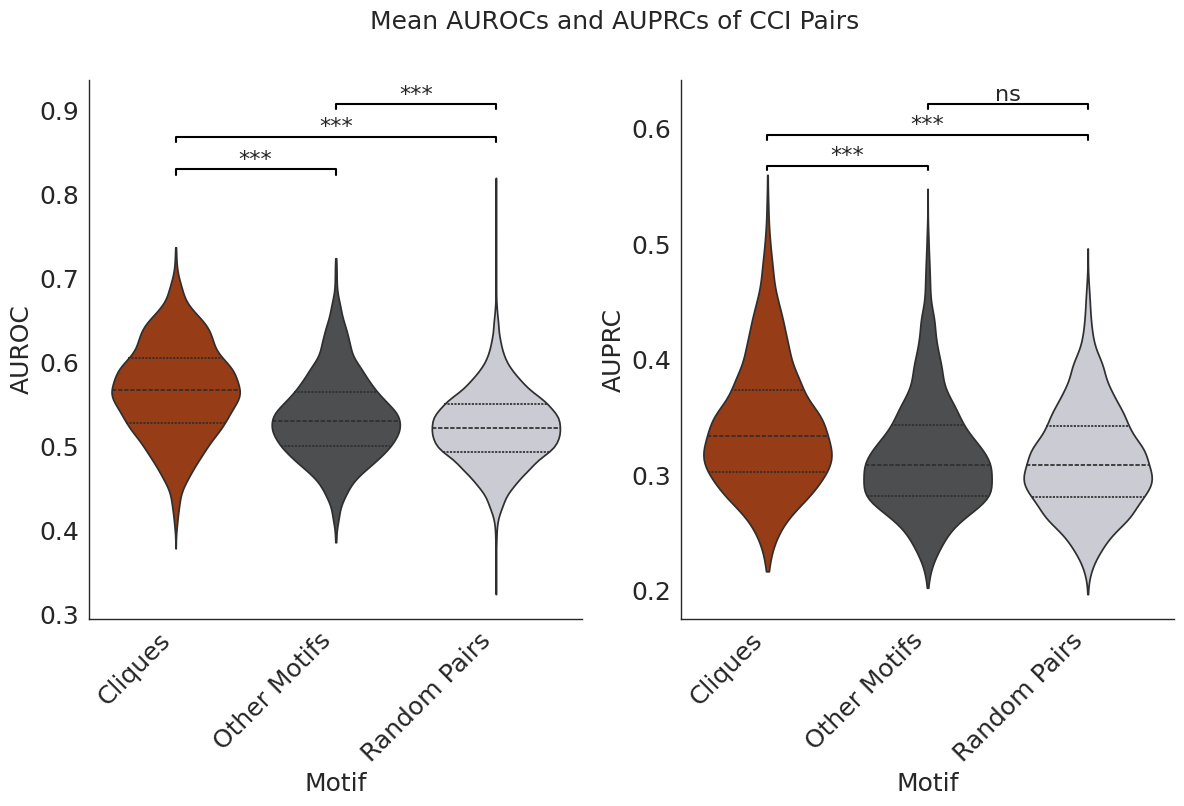

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import itertools
import numpy as np

fs = 18

palette = {'Random Pairs': lightgray, 'Other Motifs': graycolor, 'Cliques': tcolor}

# Sort motif categories by median AUROC
median_auroc = df_mean.groupby('motif')['mean_auroc'].median().sort_values(ascending=False)
sorted_motifs = median_auroc.index.tolist()

# Reorder palette to match sorted motifs
palette_sorted = {motif: palette[motif.title().replace('_', ' ')] if motif.title().replace('_', ' ') in palette else 'gray' for motif in sorted_motifs}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot violinplots with sorted order
sns.violinplot(data=df_mean, y='mean_auroc', x='motif', order=sorted_motifs, palette=palette_sorted, ax=ax1, inner='quart', cut=0)
sns.violinplot(data=df_mean, y='mean_auprc', x='motif', order=sorted_motifs, palette=palette_sorted, ax=ax2, inner='quart', cut=0)

# Prepare all pairs for comparison
pairs = list(itertools.combinations(sorted_motifs, 2))

# Function to get p-value for pair and metric
def get_pval(group1, group2, metric):
    data1 = df_mean.query(f'motif == "{group1}"')[metric].dropna()
    data2 = df_mean.query(f'motif == "{group2}"')[metric].dropna()
    return mannwhitneyu(data1, data2).pvalue

# Significance label function
def get_sig_label(pval):
    if pval > 0.05:
        return "ns"
    elif pval > 0.01:
        return "*"
    elif pval > 0.001:
        return "**"
    else:
        return "***"
    return

# Function to add significance bars for all pairs
def add_all_significance_bars(ax, metric, y_start=0.05, y_step=0.05, height=0.008):
    ylim = ax.get_ylim()
    y_max = 0.92*ylim[1]
    
    for i, (g1, g2) in enumerate(pairs):
        pval = get_pval(g1, g2, metric)
        x1, x2 = sorted_motifs.index(g1), sorted_motifs.index(g2)
        y = y_max + y_start * y_max + i * y_step * y_max
        
        # Draw bar
        ax.plot([x1, x1, x2, x2], [y, y + height * y_max, y + height * y_max, y], lw=1.5, c='black')
        ax.text((x1 + x2) / 2, y + height * y_max, get_sig_label(pval), ha='center', va='bottom', fontsize=fs*0.9)

# Add significance bars to each plot
add_all_significance_bars(ax1, 'mean_auroc', y_start=0.06)
add_all_significance_bars(ax2, 'mean_auprc', y_start=0.06)

ax1.set_ylabel('AUROC')
ax2.set_ylabel('AUPRC')

# Formatting axes
for ax in (ax1, ax2):
    ax.tick_params(axis='both', labelsize=fs)
    ax.set_xlabel(ax.get_xlabel().title(), fontsize=fs)
    ax.set_ylabel(ax.get_ylabel().upper(), fontsize=fs)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels([label.get_text().title().replace('_', ' ') for label in ax.get_xticklabels()], rotation=45, ha='right')

fig.suptitle('Mean AUROCs and AUPRCs of CCI Pairs', fontsize=fs)

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/individual_pairs_auroc_auprc_violinplot.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/individual_pairs_auroc_auprc_violinplot.png', bbox_inches='tight', dpi=300)    

plt.show()


In [24]:
better = crosstalkdf.query('auroc > auroc1 and auroc > auroc2')
better = better.query('auprc > auprc1 and auprc > auprc2')

In [25]:
better

interaction     auroc    auroc1  \
103591      ENTPD1+ADORA3&GAD2_SLC6A13+GABRA1_GABRB2  1.000000  0.884211   
103305                       CXCL10+CXCR3&MRC1+PTPRC  1.000000  0.673684   
103384  SEMA4D+PTPRC&GAD2_SLC6A1+GABRA1_GABRB2_GABRD  1.000000  0.673684   
104822         GAD2_SLC6A6+GABBR1&GDF2+ACVR2A_ACVRL1  1.000000  0.968421   
103443                         CXCL12+DPP4&GAD2+GRM1  1.000000  0.631579   
...                                              ...       ...       ...   
91250            HSD3B1+CATSPER1_CATSPERD&LAMA1+SV2A  0.236111  0.180556   
46339       INHA_INHBA+ACVR1C_ACVR2A&MDK+ITGA6_ITGB1  0.230952  0.169048   
91275                           PGF+FLT1&SEMA4D+CD72  0.208333  0.097222   
105283        COL22A1+ITGA1_ITGB1&COL6A3+ITGA1_ITGB1  0.178947  0.157895   
105487        COL10A1+ITGA1_ITGB1&COL6A3+ITGA1_ITGB1  0.168421  0.136842   

          auroc2     auprc    auprc1    auprc2  auroc_diff  auprc_diff  \
103591  0.831579  1.000000  0.564444  0.597222    0.115789    0.402778   
103305  0.757895  1.000000  0.435948  0.508824    0.242105    0.491176   
103384  0.831579  1.000000  0.325227  0.597222    0.168421    0.402778   
104822  0.568421  1.000000  0.925000  0.307381    0.031579    0.075000   
103443  0.852632  1.000000  0.351812  0.674603    0.147368    0.325397   
...          ...       ...       ...       ...         ...         ...   
91250   0.222222  0.145833  0.137012  0.143750    0.013889    0.002083   
46339   0.219048  0.179836  0.168484  0.176271    0.011905    0.003565   
91275   0.194444  0.142038  0.127127  0.139531    0.013889    0.002507   
105283  0.147368  0.152815  0.148960  0.150021    0.021053    0.002794   
105487  0.147368  0.150166  0.145389  0.150021    0.021053    0.000145   

               motif            tissue  
103591  Random Pairs            ureter  
103305       Cliques            ureter  
103384  Random Pairs            ureter  
104822  Random Pairs            ureter  
103443  Random Pairs            ureter  
...              ...               ...  
91250   Random Pairs  lymphatic_tissue  
46339   Random Pairs              lung  
91275   Random Pairs  lymphatic_tissue  
105283       Cliques            ureter  
105487       Cliques            ureter  

[24484 rows x 11 columns]

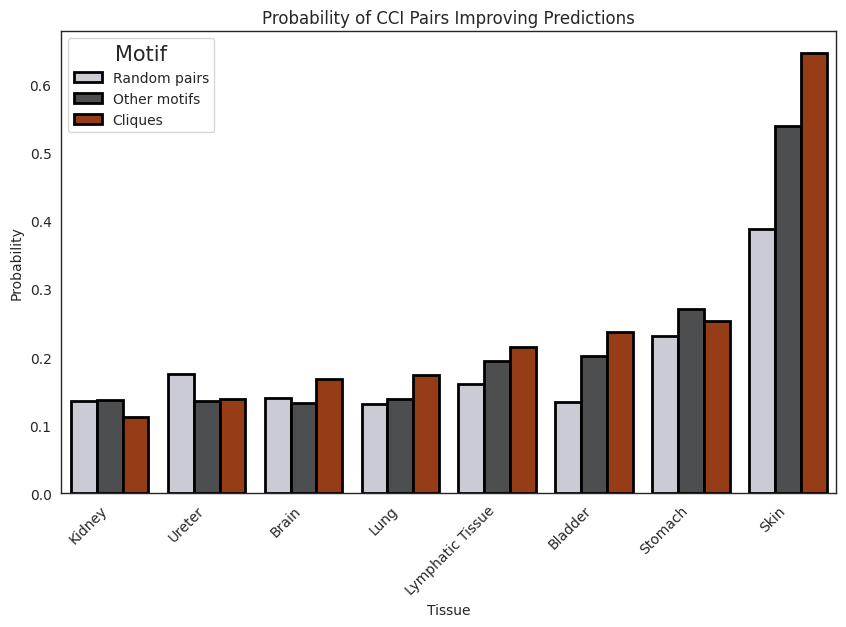

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Compute probabilities separately for each tissue
probs_by_tissue = []
for tissue, better_group in better.groupby('tissue'):
    crosstalk_group = crosstalkdf[crosstalkdf['tissue'] == tissue]
    
    probs = (better_group.dropna().motif.value_counts() / crosstalk_group.dropna().motif.value_counts()).dropna()
    
    df = probs.reset_index()
    df.columns = ['motif', 'prob']
    df['tissue'] = tissue
    probs_by_tissue.append(df)

# Combine results
plot_df = pd.concat(probs_by_tissue)

# Sort tissues by "cliques" probability (ascending order)
tissue_order = (
    plot_df[plot_df['motif'] == 'Cliques']
    .sort_values(by='prob', ascending=True)['tissue']
    .tolist()
)

# Set tissue as categorical with the specified order
plot_df['tissue'] = pd.Categorical(plot_df['tissue'], categories=tissue_order, ordered=True)

# Plot barplot
plt.figure(figsize=(10, 6))
#palette={'cliques': orangecolor, 'random_pairs':lightgray}
#palette={'cliques': tcolor, 'random_pairs': ncolor}
palette = {'Random Pairs': lightgray, 'Other Motifs': graycolor, 'Cliques': tcolor}

hue_order=['Random Pairs', 'Other Motifs', 'Cliques']
sns.barplot(data=plot_df, x='tissue', y='prob', hue='motif', palette=palette, linewidth=2, edgecolor='k', hue_order=hue_order)

# Improve x-axis readability
plt.xticks(rotation=45, ha='right')

# Capitalize x labels and replace underscores with spaces
new_labels = [label.get_text().title().replace('_', ' ') for label in plt.gca().get_xticklabels()]
plt.gca().set_xticklabels(new_labels)

# Capitalize legend labels and replace underscores with spaces
handles, labels = plt.gca().get_legend_handles_labels()
new_labels_legend = [label.capitalize().replace('_', ' ') for label in labels]
plt.legend(handles=handles, labels=new_labels_legend, title='Motif')

plt.xlabel('Tissue')
plt.ylabel('Probability')
plt.title('Probability of CCI Pairs Improving Predictions')

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/individual_pairs_tissues_prob_better.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/individual_pairs_tissues_prob_better.png', bbox_inches='tight', dpi=300)    

plt.show()

# Heatmap Top by Mean Across Tissues

In [27]:
## Read the results
parentdir = '/home/lnemati/pathway_crosstalk/results/immunotherapy/individual_interactions_and_motifs'

dfs = []

for tissue in os.listdir(parentdir):
    #if tissue in ['full_dataset']: # add back lymph and ureter when they finish running
    #    continue
    path = os.path.join(parentdir, tissue, 'aggregated', 'aggregated.csv')
    tissuedf = pd.read_csv(os.path.join(path))
    tissuedf = tissuedf.rename(columns={'Unnamed: 0': 'interaction'})
    #tissuedf['motif'] = tissuedf['motif'].replace({'3_clique': 'cliques', '4_clique': 'cliques'})

    dfs.append(tissuedf)
        
crosstalkdf = pd.concat(dfs, ignore_index=True)
#crosstalkdf = crosstalkdf.dropna()

crosstalkdf = crosstalkdf.sort_values(by='auroc')[::-1]

crosstalkdf = crosstalkdf.query('motif in ["3_clique", "4_clique"]')
#crosstalkdf = crosstalkdf.query('tissue != "full_dataset"')

better = crosstalkdf.query('auroc > auroc1 and auroc > auroc2')
better = better.query('auprc > auprc1 and auprc > auprc2')

crosstalkdf['orig_name'] = crosstalkdf['interaction']
better['orig_name'] = better['interaction']

crosstalkdf['interaction'] = crosstalkdf.interaction.str.replace('_', ' - ').str.replace('+', ' - ').str.replace('&', ' & ')
better['interaction'] = better.interaction.str.replace('_', ' - ').str.replace('+', ' - ').str.replace('&', ' & ')

# Get top interactions by mean auroc
crosstalkdf['auroc_filled'] = crosstalkdf['auroc'].copy()
crosstalkdf['auroc_filled'] = crosstalkdf.groupby('tissue')['auroc_filled'].transform(lambda x: x.fillna(x.mean()))

interactions_show = crosstalkdf.groupby('interaction')['auroc_filled'].mean().sort_values()[::-1].head(50).index.tolist()

# Get top interactions in each tissue
#interactions_show = better.sort_values(by='auroc')[::-1].groupby('tissue').head(5).interaction.tolist()

# Filter crosstalkdf for these top interactions only
# Prepare pivot
aurocs_df = crosstalkdf.pivot_table(
    index='interaction',
    columns='tissue',
    values='auroc',
    aggfunc='mean'
)

aurocs_df['interaction'] = aurocs_df.index

aurocs_df = aurocs_df[aurocs_df['interaction'].isin(interactions_show)]
#aurocs_df['interaction'] = aurocs_df.interaction.str.replace('_', ' - ').str.replace('+', ' - ').str.replace('&', ' & ')

import re

# Split interactions into individual genes for each side
aurocs_df['interaction1'] = aurocs_df.interaction.apply(lambda x: re.split('&', x)[0].strip().split(' - '))
aurocs_df['interaction2'] = aurocs_df.interaction.apply(lambda x: re.split('&', x)[1].strip().split(' - '))

# Load hallmark gene sets
def read_gmt(file_path):
    gene_sets = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                gene_sets[parts[0]] = set(parts[2:])
    return gene_sets

hallmarks_path = '/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt'
hallmarks = read_gmt(hallmarks_path)

# Generate cleaned hallmark labels
labels = [label.replace('HALLMARK_', '').replace('_', ' ').title() for label in hallmarks.keys()]

replace = {
    'Myc': 'MYC',
    'Kras': 'KRAS',
    'Il2': 'IL2',
    'Stat5': 'STAT5',
    'Il6': 'IL6',
    'Jak': 'JAK',
    'Stat3': 'STAT3',
    'P53': 'P53',
    'Tnfa': 'TNFα',
    'Nfkb': 'NF-κB',
    'Mtorc1': 'mTORC1',
    'Mtorc': 'mTORC',
    'Mtor': 'mTOR',
    ' Dn': ' Down',
    'Pi3K': 'PI3K',
    ' Akt': ' AKT',
    'Epithelial Mesenchymal Transition': 'E-M Transition'
}

for str1, str2 in replace.items():
    labels = [label.replace(str1, str2) for label in labels]

hallmark_name_map = dict(zip(hallmarks.keys(), labels))

# Function to find matching hallmark sets for a given gene list
def find_matching_hallmarks(gene_list, hallmark_sets):
    return [name for name, genes in hallmark_sets.items() if set(gene_list) & genes]

# Get hallmarks for each side of the interaction
aurocs_df['hallmarks1'] = aurocs_df['interaction1'].apply(lambda genes: find_matching_hallmarks(genes, hallmarks))
aurocs_df['hallmarks2'] = aurocs_df['interaction2'].apply(lambda genes: find_matching_hallmarks(genes, hallmarks))

# Convert to readable labels using the name map
aurocs_df['hallmarks1'] = aurocs_df['hallmarks1'].apply(lambda hlist: [hallmark_name_map[h] for h in hlist])
aurocs_df['hallmarks2'] = aurocs_df['hallmarks2'].apply(lambda hlist: [hallmark_name_map[h] for h in hlist])

crosstalkdf_with_orig_name = crosstalkdf.copy()

In [28]:
import numpy as np

# Define subset of hallmarks you want to consider (for example, top N or all unique found)
# For demonstration, use all unique hallmarks found across both sides:
all_hallmarks = sorted(set(sum(aurocs_df['hallmarks1'], [])) | set(sum(aurocs_df['hallmarks2'], [])))

# Initialize matrix: rows = interactions, columns = hallmarks
heatmap_matrix = np.zeros((len(aurocs_df), len(all_hallmarks)), dtype=int)

# Fill matrix with presence codes
for i, row in enumerate(aurocs_df.itertuples(index=False)):
    hallmarks_1 = set(row.hallmarks1)
    hallmarks_2 = set(row.hallmarks2)
    for j, hallmark in enumerate(all_hallmarks):
        in_1 = hallmark in hallmarks_1
        in_2 = hallmark in hallmarks_2
        heatmap_matrix[i, j] = 1 * in_1 + 2 * in_2  # 0, 1, 2, or 3

heatmap_df = pd.DataFrame(heatmap_matrix, index=aurocs_df.interaction, columns=all_hallmarks)    
heatmap_df = heatmap_df[::-1] # Invert to match order of the plot

# Values:
# 0 = not present
# 1 = interaction1
# 2 = interaction2
# 3 = both interactions

aurocs_df = aurocs_df[['bladder', 'brain', 'full_dataset', 'kidney', 'lung', 'lymphatic_tissue', 'skin', 'stomach', 'ureter']]
cols = [col.title().replace('_', ' ') for col in aurocs_df.columns]
aurocs_df.columns = cols

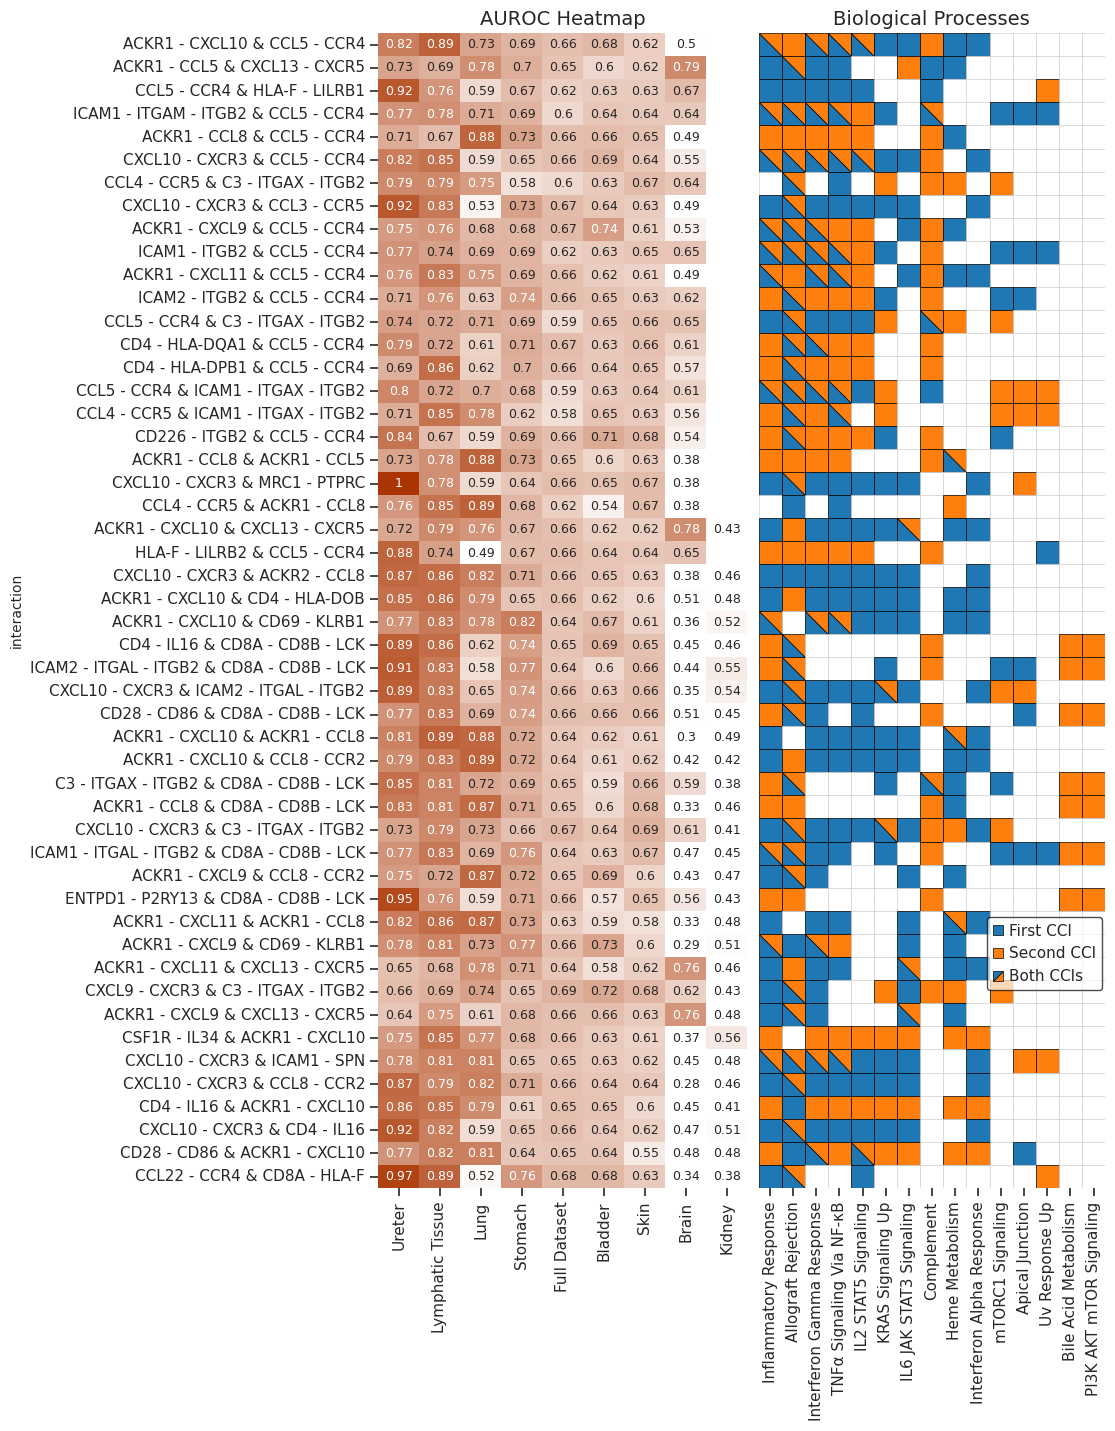

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
from matplotlib.legend_handler import HandlerBase

# --- Settings ---
titlefs = 14
fs = 11
smallfs = 9
height = 0.8

####### CLSUTER HEATMAP
#
## Fill NaNs in aurocs_df by the mean of each tissue (column)
#aurocs_filled = aurocs_df.apply(lambda col: col.fillna(col.mean()), axis=0)
#
## Perform clustering on the filled data
#cluster = sns.clustermap(
#    aurocs_filled,
#    row_cluster=True,
#    col_cluster=True,
#)
#plt.close(cluster.fig)
# Extract new ordering from the clustermap
#order_interactions = aurocs_df.index[cluster.dendrogram_row.reordered_ind]
#order_tissues = aurocs_df.columns[cluster.dendrogram_col.reordered_ind]
# Reorder AUROC dataframe
#aurocs_df = aurocs_df.loc[order_interactions, order_tissues]

####### JUST SORT BY MEAN VALUE
order_tissues = aurocs_df.mean(axis=0).sort_values(ascending=False).index
order_interactions = aurocs_df.mean(axis=1).sort_values(ascending=False).index
aurocs_df = aurocs_df.loc[order_interactions, order_tissues]

# Heatmap prep
N = 15
hallmark_counts = (heatmap_df != 0).sum(axis=0)
top_hallmarks = hallmark_counts.sort_values(ascending=False).head(N).index
top_heatmap_df = heatmap_df[top_hallmarks]
top_heatmap_df = top_heatmap_df.loc[aurocs_df.index]
hallmark_matrix = top_heatmap_df.values

# --- Plotting ---
fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(1, 3, width_ratios=[1., 1., 0.1], wspace=0.)
ax = fig.add_subplot(gs[0])      # AUROC heatmap
ax_hm = fig.add_subplot(gs[1])   # Biological process heatmap
#ax_cbar = fig.add_subplot(gs[2]) # Colorbar

# --- Left: AUROC heatmap via seaborn ---
vmin, vmax = 0.5, 1.0
cmap = mcolors.LinearSegmentedColormap.from_list("white_to_color", ["white", tcolor])

sns.heatmap(
    aurocs_df,
    annot=True,
    cmap=cmap,
    #cbar_ax=ax_cbar,
    cbar=False,
    ax=ax,
    vmin=vmin,
    vmax=vmax,
    annot_kws={"fontsize": smallfs}
)

# --- Right: Process Heatmap using patches ---
ax_hm.set_yticks([])  # Hide y ticks
ax_hm.set_xticks(np.arange(hallmark_matrix.shape[1]) + 0.5)
ax_hm.set_xticklabels(top_heatmap_df.columns, rotation=90, fontsize=fs)

# Minor ticks for grid lines
#ax_hm.set_xticks(np.arange(hallmark_matrix.shape[1] + 1), minor=True)
ax_hm.set_yticks(np.arange(hallmark_matrix.shape[0] + 1), minor=True)
ax_hm.grid(which='minor', color='white', linewidth=2.5)
ax_hm.tick_params(which='minor', bottom=False, left=False, length=6, width=1.2)
ax_hm.tick_params(axis='x', which='both', bottom=True, top=False, length=6, width=1.2)

# Draw cells
for i in range(hallmark_matrix.shape[0]):
    for j in range(hallmark_matrix.shape[1]):
        val = hallmark_matrix[i, j]
        if val == 0:
            facecolor = 'white'
            edgecolor = 'lightgray'
            rect = patches.Rectangle((j, i), 1, 1, facecolor=facecolor, edgecolor=edgecolor, linewidth=0.5)
            ax_hm.add_patch(rect)
        elif val == 1:
            rect = patches.Rectangle((j, i), 1, 1, facecolor='C0', edgecolor='k', linewidth=0.5)
            ax_hm.add_patch(rect)
        elif val == 2:
            rect = patches.Rectangle((j, i), 1, 1, facecolor='C1', edgecolor='k', linewidth=0.5)
            ax_hm.add_patch(rect)
        elif val == 3:
            tri1 = patches.Polygon([(j, i), (j, i + 1), (j + 1, i + 1)], facecolor='C0', edgecolor='k', linewidth=0.5)
            tri2 = patches.Polygon([(j, i), (j + 1, i), (j + 1, i + 1)], facecolor='C1', edgecolor='k', linewidth=0.5)
            ax_hm.add_patch(tri1)
            ax_hm.add_patch(tri2)

ax_hm.set_xlim(0, hallmark_matrix.shape[1])
ax_hm.set_ylim(hallmark_matrix.shape[0], 0)
ax_hm.set_aspect('equal', adjustable='box')
ax_hm.set_title('Biological Processes', fontsize=titlefs)

# --- Legend with split square for "Both Interactions" ---
class HandlerSplitSquare(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        tri1 = patches.Polygon([[xdescent, ydescent],
                                [xdescent, ydescent + height],
                                [xdescent + width, ydescent + height]],
                               facecolor='C0', edgecolor='k', linewidth=0.5, transform=trans)
        tri2 = patches.Polygon([[xdescent, ydescent],
                                [xdescent + width, ydescent],
                                [xdescent + width, ydescent + height]],
                               facecolor='C1', edgecolor='k', linewidth=0.5, transform=trans)
        return [tri1, tri2]

patch_c0 = patches.Rectangle((0, 0), 1, 1, facecolor='C0', edgecolor='k', linewidth=0.5)
patch_c1 = patches.Rectangle((0, 0), 1, 1, facecolor='C1', edgecolor='k', linewidth=0.5)
split_square_handle = object()

ax_hm.legend(
    handles=[patch_c0, patch_c1, split_square_handle],
    labels=['First CCI', 'Second CCI', 'Both CCIs'],
    handler_map={split_square_handle: HandlerSplitSquare()},
    loc='lower center',
    bbox_to_anchor=(0.825, 0.165),
    fontsize=fs,
    ncol=1,
    frameon=True,
    facecolor='white',
    framealpha=0.7,
    edgecolor='black',
    handlelength=0.65,
    handleheight=0.65,
    handletextpad=0.4,
)

# --- Spine visibility ---
for spine in ax.spines.values():
    spine.set_visible(False)
for spine in ax_hm.spines.values():
    spine.set_visible(False)

# --- Tick parameters consistent with your original style ---
ax.tick_params(bottom=True, top=False, left=True, labelbottom=True, labelsize=fs, length=6, width=1.2)
ax_hm.tick_params(bottom=True, top=False, left=False, labelbottom=True, labelsize=fs, length=6, width=1.2)

# --- Titles ---
ax.set_title('AUROC Heatmap', fontsize=titlefs)
ax_hm.set_title('Biological Processes', fontsize=titlefs)

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/aurocs_heatmap.pdf', bbox_inches='tight', dpi=300)
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/aurocs_heatmap.png', bbox_inches='tight', dpi=300)

plt.show()


tissue: bladder


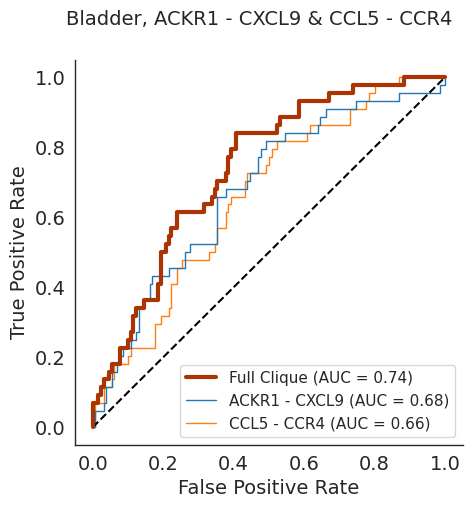

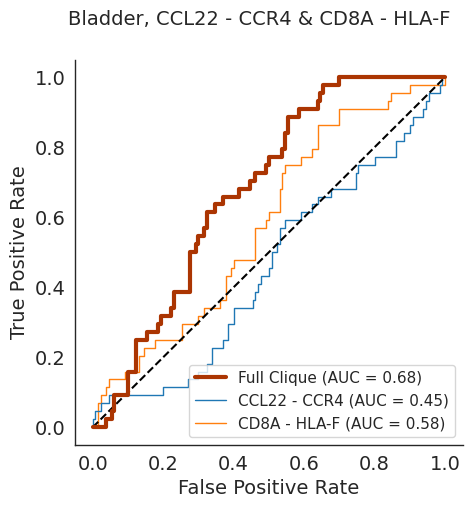

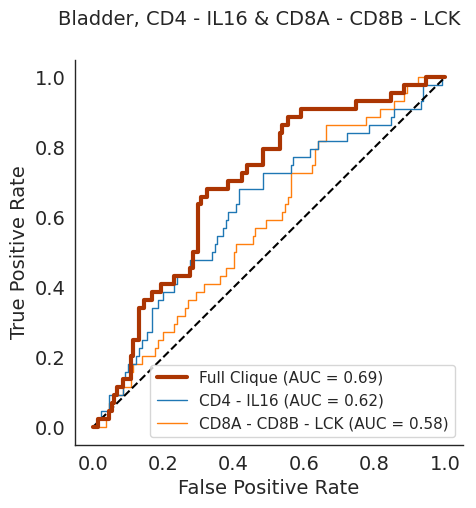

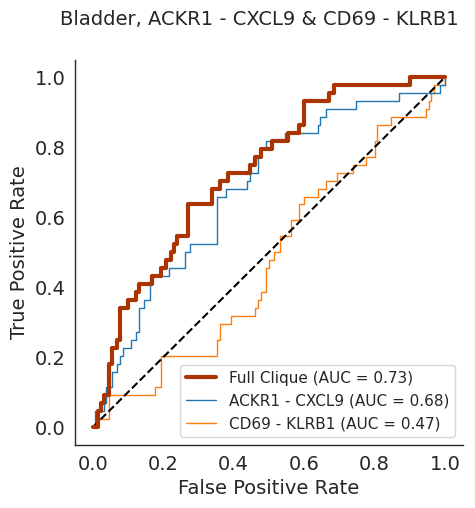

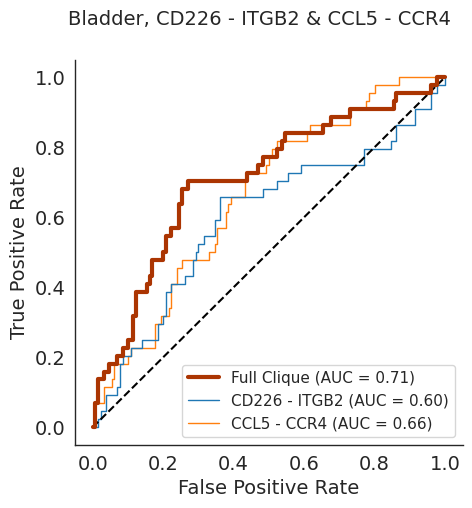

tissue: brain


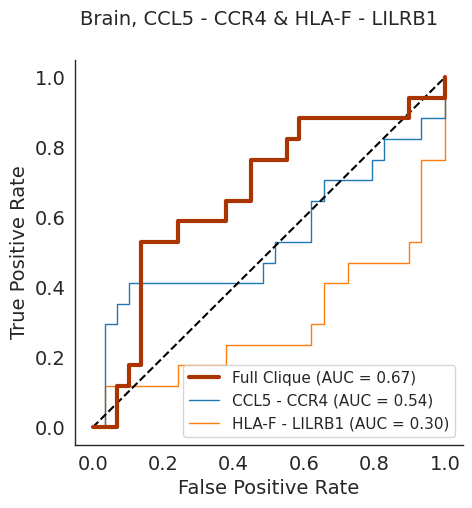

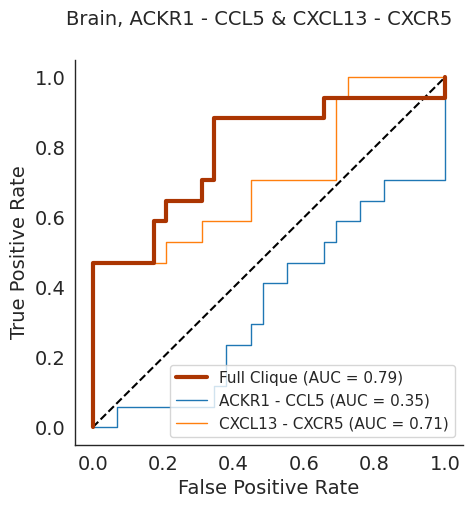

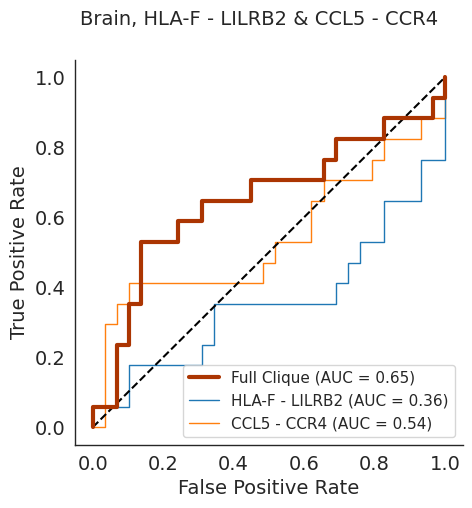

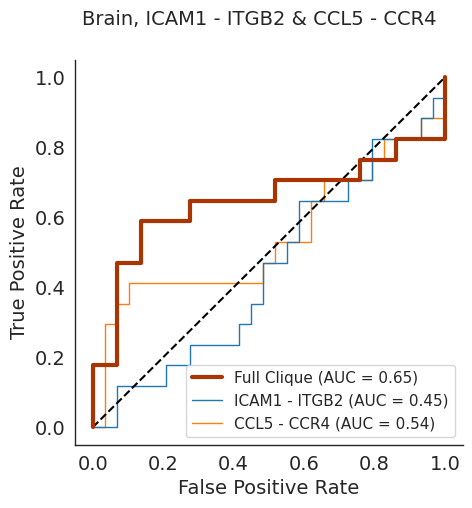

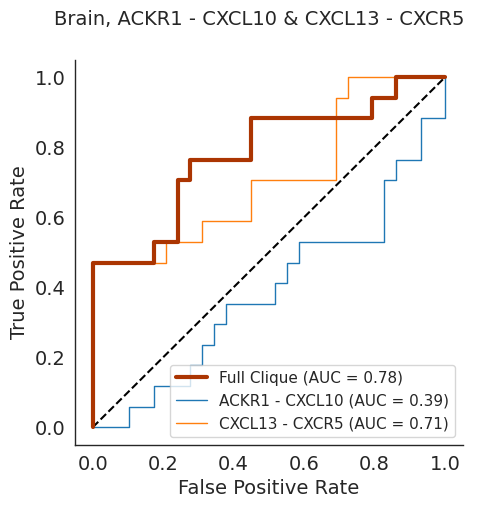

tissue: full_dataset


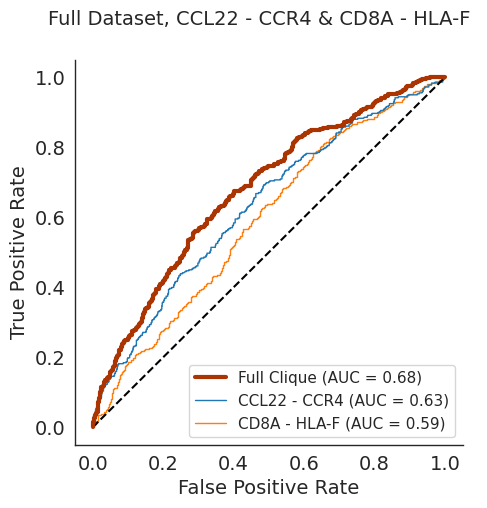

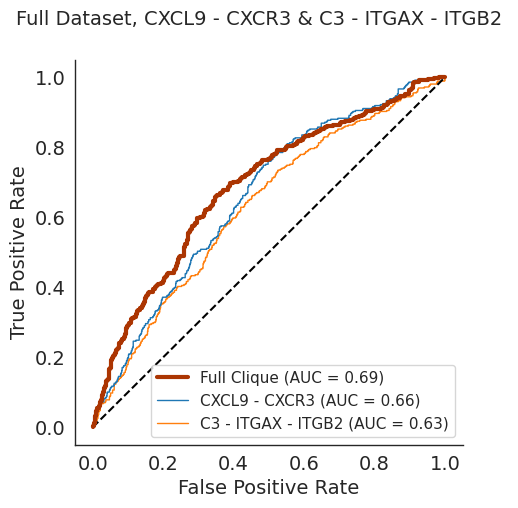

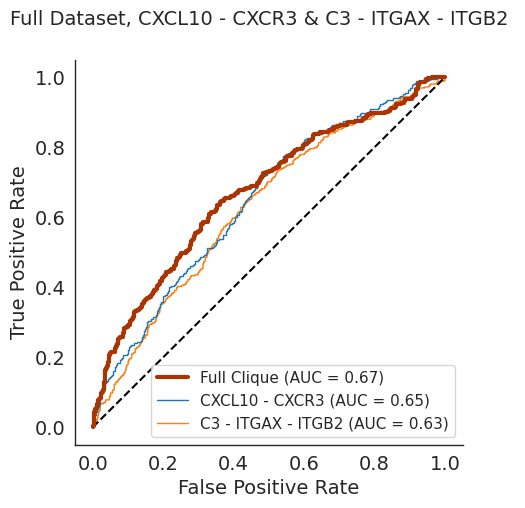

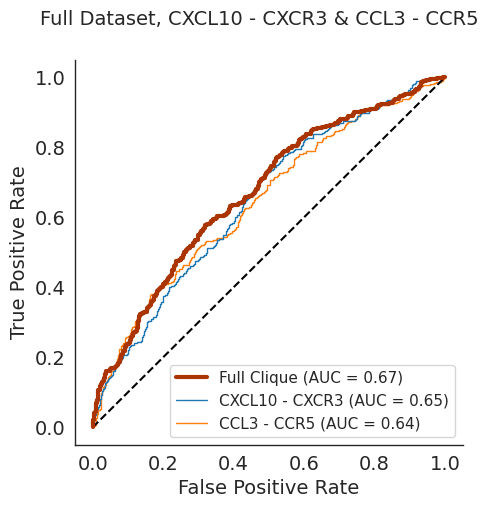

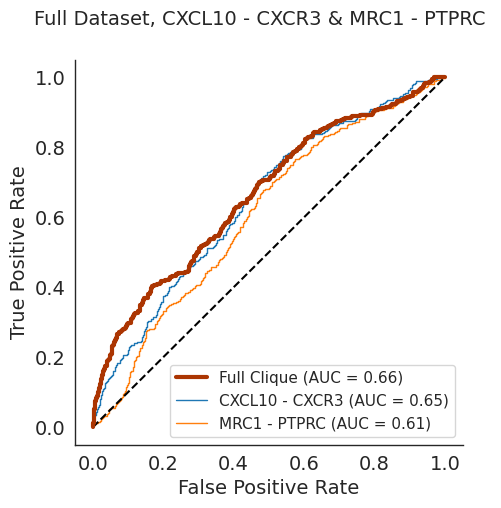

tissue: lung


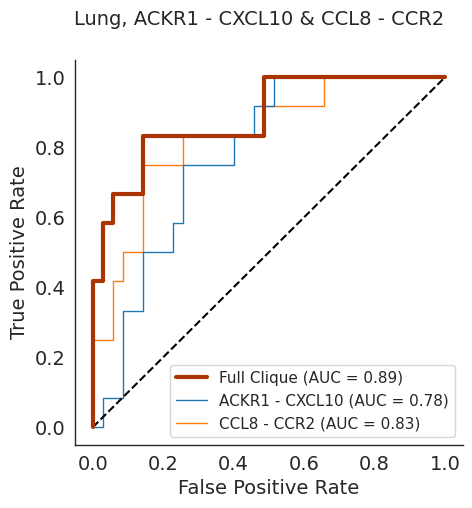

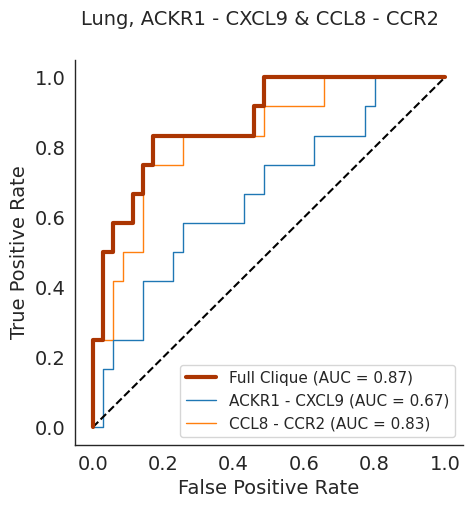

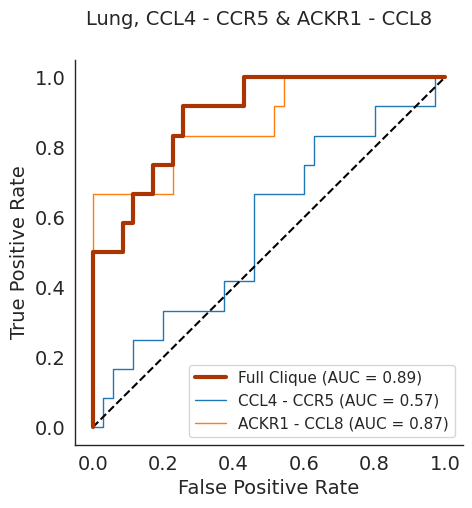

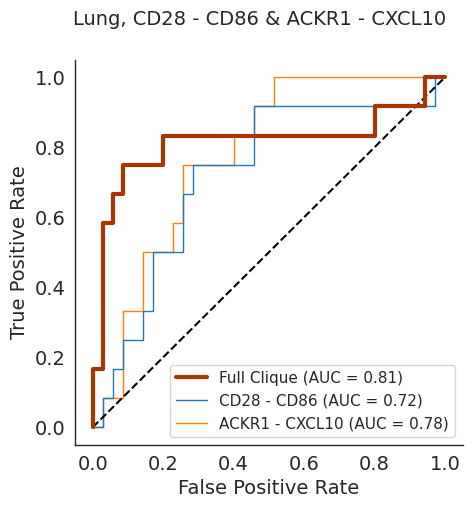

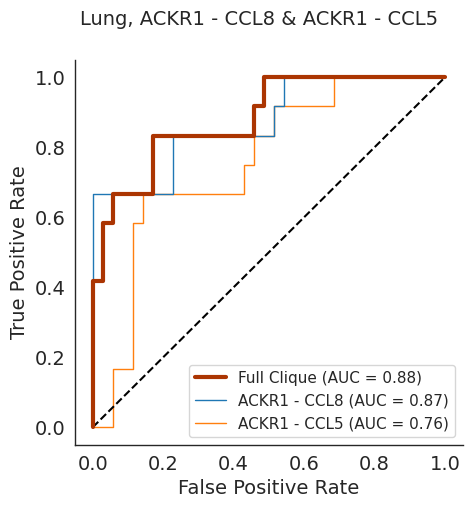

tissue: skin


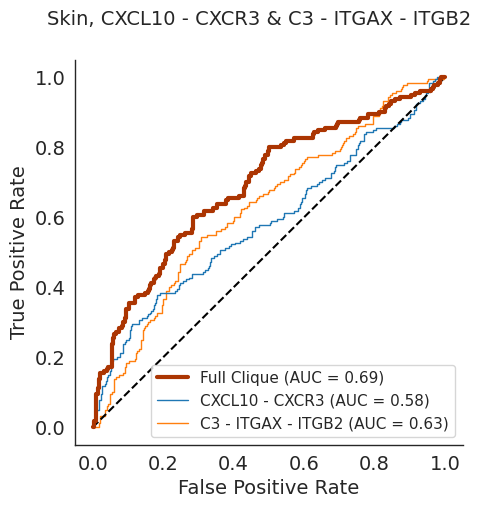

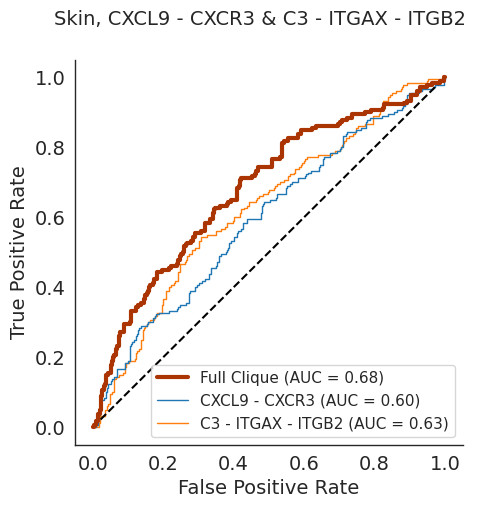

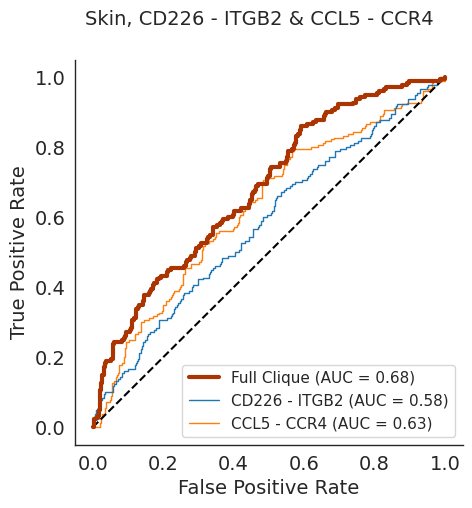

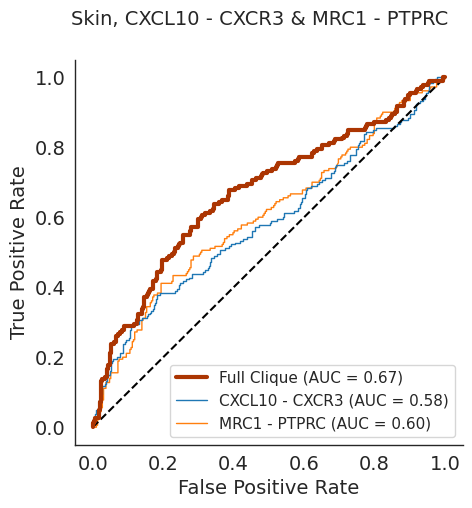

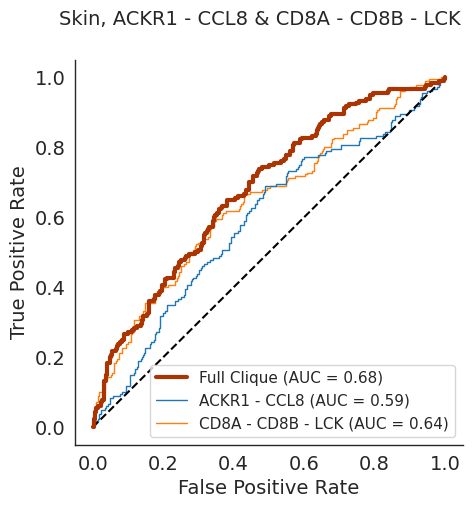

tissue: stomach


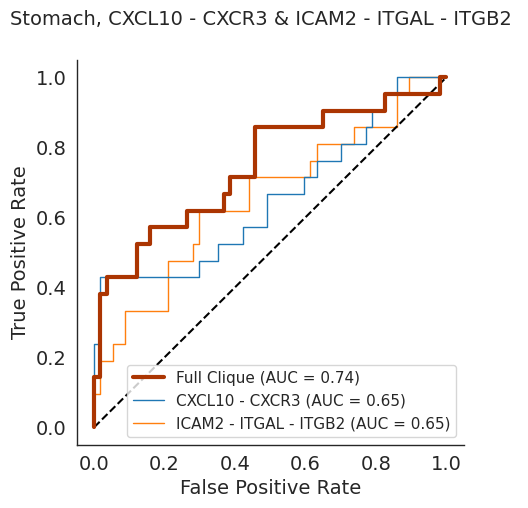

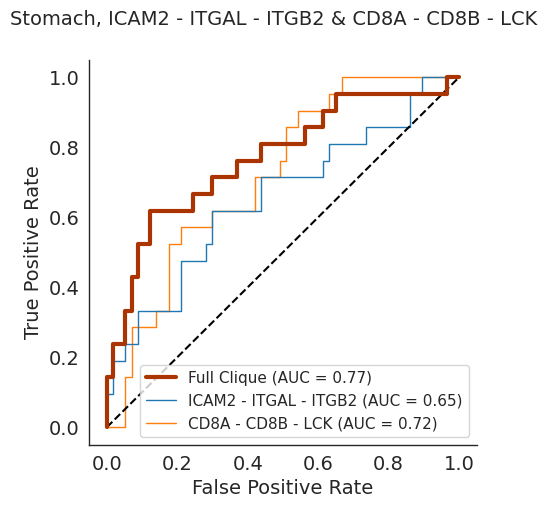

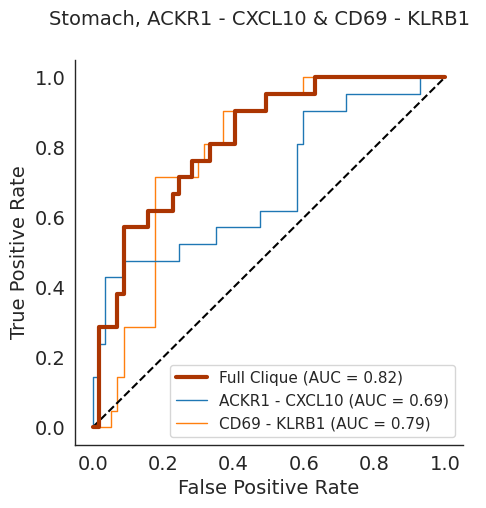

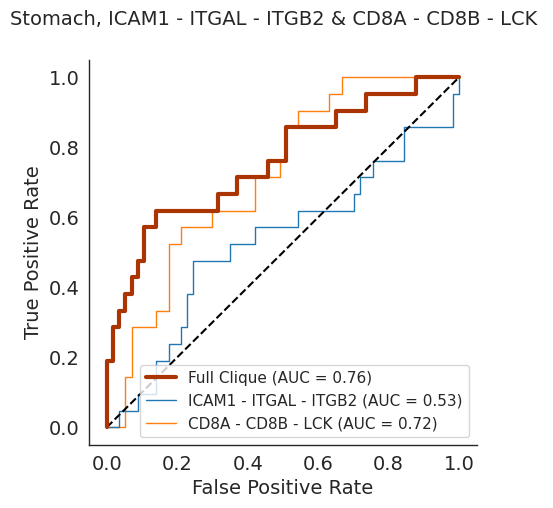

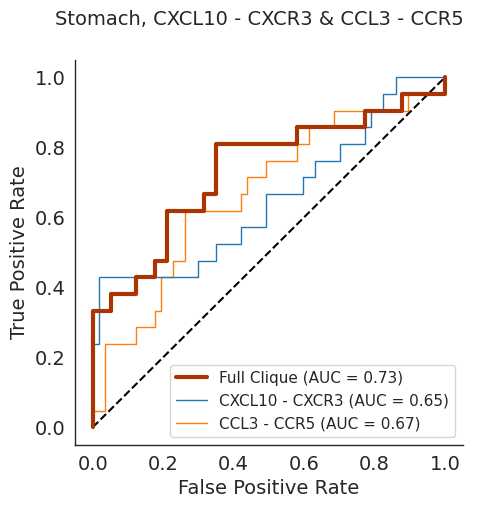

In [30]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from  sklearn.metrics import roc_curve, auc

to_plot = crosstalkdf.set_index('interaction').loc[aurocs_df.index]
# only keep those with auroc_diff > 0
to_plot = to_plot[to_plot['auroc_diff'] > 0].reset_index()
# sort the interactions based on rank aggregate auroc and auroc_diff
to_plot['rank_auroc'] = to_plot.groupby('tissue')['auroc'].rank(ascending=False, method='first')
to_plot['rank_auroc_diff'] = to_plot.groupby('tissue')['auroc_diff'].rank(ascending=False, method='first')
to_plot['rank'] = to_plot['rank_auroc'] + to_plot['rank_auroc_diff']
to_plot = to_plot.sort_values(by='rank').reset_index(drop=True)
# take top interactions per tissue
to_plot = to_plot.groupby('tissue').head(5).reset_index()

parentdir = '/home/lnemati/pathway_crosstalk/results/immunotherapy/individual_interactions_and_motifs'

# Define colors for each plot (just for better visibility)
colors = [tcolor, 'C0', 'C1']

# Set font size for all elements
fs = 14
legendfs = 11
plt.rcParams.update({'font.size': fs})  # Update the global font size

# Loop over the top 3 interactions per tissue
for tissue, group in to_plot.groupby('tissue'):
    if tissue not in ['full_dataset', 'brain', 'lung', 'bladder', 'skin', 'stomach']:
        continue  # Skip tissues with few patients

    print(f"tissue: {tissue}")

    path = os.path.join(parentdir, tissue, 'prediction_probabilities')
    clique3 = pd.read_csv(os.path.join(path, '3_clique.csv'), index_col=0)
    clique4 = pd.read_csv(os.path.join(path, '4_clique.csv'), index_col=0)
    individual_ccis = pd.read_csv(os.path.join(path, 'individual_ccis.csv'), index_col=0)


    df = pd.concat([
        pd.read_csv(os.path.join(path, '3_clique.csv'), index_col=0),
        pd.read_csv(os.path.join(path, '4_clique.csv'), index_col=0),
        pd.read_csv(os.path.join(path, 'individual_ccis.csv'), index_col=0),
    ])
        
    # Convert all_genes to sorted tuples
    df['all_genes'] = pd.Series(df.index, index=df.index).apply(lambda x: tuple(sorted(set(re.split('[&+_]', x)))))
        
    # Loop over the top 3 interactions for this tissue
    for idx, row in group.iterrows():
        interaction = row.orig_name
        int1, int2 = interaction.split('&')

        # Get the probability for the best interaction and the individual interactions
        clique_probs = df[df['all_genes'] == tuple(sorted(set(re.split('[&+_]', interaction))))]    
        int1_probs = df[df['all_genes'] == tuple(sorted(set(re.split('[&+_]', int1))))]    
        int2_probs = df[df['all_genes'] == tuple(sorted(set(re.split('[&+_]', int2))))]    
        
        # skip if any of the DataFrames contains nans
        if clique_probs.isna().any().any() or int1_probs.isna().any().any() or int2_probs.isna().any().any():
            continue

        clique_probs = clique_probs.drop(columns='all_genes')
        int1_probs = int1_probs.drop(columns='all_genes')
        int2_probs = int2_probs.drop(columns='all_genes')
        
        # Ensure there is data in these DataFrames
        if len(clique_probs) == 0 or len(int1_probs) == 0 or len(int2_probs) == 0:
            continue
        
        # Extract true labels, convert 'R' to 1 and 'N' to 0
        true_labels = df.iloc[0].map({'R': 1, 'N': 0}).drop('all_genes')  # Convert 'R' to 1 (positive) and 'N' to 0 (negative)
        
        # Extract the predicted probabilities (assuming they're in the first column of the data)
        clique_prob_values = clique_probs.iloc[0].values.astype(float)  # Modify this as per the correct column
        int1_prob_values = int1_probs.iloc[0].values.astype(float)  # Modify this as per the correct column
        int2_prob_values = int2_probs.iloc[0].values.astype(float)  # Modify this as per the correct column

        # Compute ROC curve and AUC for each
        fpr_clique, tpr_clique, _ = roc_curve(true_labels, clique_prob_values)
        fpr_int1, tpr_int1, _ = roc_curve(true_labels, int1_prob_values)
        fpr_int2, tpr_int2, _ = roc_curve(true_labels, int2_prob_values)

        auc_clique = auc(fpr_clique, tpr_clique)
        auc_int1 = auc(fpr_int1, tpr_int1)
        auc_int2 = auc(fpr_int2, tpr_int2)

        int1_clean = int1.replace('_', ' - ').replace('+', ' - ').replace('&', ' & ')
        int2_clean = int2.replace('_', ' - ').replace('+', ' - ').replace('&', ' & ')
        title_clean = interaction.replace('_', ' - ').replace('+', ' - ').replace('&', ' & ')

        # Initialize a figure for the ROC and Precision-Recall plot
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

        # Plot each ROC curve on the first subplot (Axes 1)
        ax.plot(fpr_clique, tpr_clique, color=colors[0], label=f'Full Clique (AUC = {auc_clique:.2f})', lw=3, zorder=3)
        ax.plot(fpr_int1, tpr_int1, color=colors[1], label=f'{int1_clean} (AUC = {auc_int1:.2f})', lw=1, zorder=2)
        ax.plot(fpr_int2, tpr_int2, color=colors[2], label=f'{int2_clean} (AUC = {auc_int2:.2f})', lw=1, zorder=1)

        # Add a diagonal line for random classifier
        ax.plot([0, 1], [0, 1], color='black', linestyle='--', label=None)

        # Customize the ROC plot
        #axes[0].set_title(f'ROC Curves for Different Interactions - {tissue}', fontsize=fs)
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
        ax.legend(loc='lower right', fontsize=legendfs)
        
        # Remove top and right spines for the ROC plot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        fig.suptitle(f"{tissue.title().replace('_', ' ')}, {title_clean} ", fontsize=fs)

        # Save the figure
        plt.savefig(f'/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/individual_cliques/new/{tissue}_{interaction}.pdf', bbox_inches='tight', dpi=300)
        plt.savefig(f'/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/individual_cliques/new/{tissue}_{interaction}.png', bbox_inches='tight', dpi=300)

        plt.show()

In [55]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_interaction_roc(
    tissue,
    interaction,
    crosstalkdf,
    parentdir,
    colors=[tcolor, 'C0', 'C1'],
    fs=14,
    legendfs=11,
    ax=None
    ):
    
    # Ensure tissue and interaction are valid
    if tissue not in crosstalkdf['tissue'].unique():
        print(f"Tissue '{tissue}' not found in top-ranked data.")
        return
    if interaction not in crosstalkdf[crosstalkdf['tissue'] == tissue]['orig_name'].values:
        print(f"Interaction '{interaction}' not found in top interactions for tissue '{tissue}'.")
        return

    path = os.path.join(parentdir, tissue, 'prediction_probabilities')
    df = pd.concat([
        pd.read_csv(os.path.join(path, '3_clique.csv'), index_col=0),
        pd.read_csv(os.path.join(path, '4_clique.csv'), index_col=0),
        pd.read_csv(os.path.join(path, 'individual_ccis.csv'), index_col=0),
    ])
    df['all_genes'] = pd.Series(df.index, index=df.index).apply(lambda x: tuple(sorted(set(re.split('[&+_]', x)))))

    int1, int2 = interaction.split('&')
    clique_probs = df[df['all_genes'] == tuple(sorted(set(re.split('[&+_]', interaction))))]    
    int1_probs = df[df['all_genes'] == tuple(sorted(set(re.split('[&+_]', int1))))]    
    int2_probs = df[df['all_genes'] == tuple(sorted(set(re.split('[&+_]', int2))))]    

    if any(x.empty or x.isna().any().any() for x in [clique_probs, int1_probs, int2_probs]):
        print("Missing or invalid data for interaction probabilities.")
        return

    clique_probs = clique_probs.drop(columns='all_genes')
    int1_probs = int1_probs.drop(columns='all_genes')
    int2_probs = int2_probs.drop(columns='all_genes')

    true_labels = df.iloc[0].map({'R': 1, 'N': 0}).drop('all_genes')

    clique_prob_values = clique_probs.iloc[0].values.astype(float)
    int1_prob_values = int1_probs.iloc[0].values.astype(float)
    int2_prob_values = int2_probs.iloc[0].values.astype(float)

    fpr_clique, tpr_clique, _ = roc_curve(true_labels, clique_prob_values)
    fpr_int1, tpr_int1, _ = roc_curve(true_labels, int1_prob_values)
    fpr_int2, tpr_int2, _ = roc_curve(true_labels, int2_prob_values)

    auc_clique = auc(fpr_clique, tpr_clique)
    auc_int1 = auc(fpr_int1, tpr_int1)
    auc_int2 = auc(fpr_int2, tpr_int2)

    int1_clean = int1.replace('_', ' - ').replace('+', ' - ').replace('&', ' & ')
    int2_clean = int2.replace('_', ' - ').replace('+', ' - ').replace('&', ' & ')
    title_clean = interaction.replace('_', ' - ').replace('+', ' - ').replace('&', ' & ')

    plt.rcParams.update({'font.size': fs})

    if ax is None:
        # Create a new figure and axis if not provided
        fig, ax = plt.subplots(figsize=(5, 5))

    ax.plot(fpr_clique, tpr_clique, color=colors[0], label=f'Full Clique (AUC = {auc_clique:.2f})', lw=3, zorder=3)
    ax.plot(fpr_int1, tpr_int1, color=colors[1], label=f'{int1_clean} (AUC = {auc_int1:.2f})', lw=1, zorder=2)
    ax.plot(fpr_int2, tpr_int2, color=colors[2], label=f'{int2_clean} (AUC = {auc_int2:.2f})', lw=1, zorder=1)
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')

    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.legend(loc='lower right', fontsize=legendfs)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(f"{tissue.title().replace('_', ' ')}, {title_clean}", fontsize=fs)
    
    if ax is None:
        plt.show()


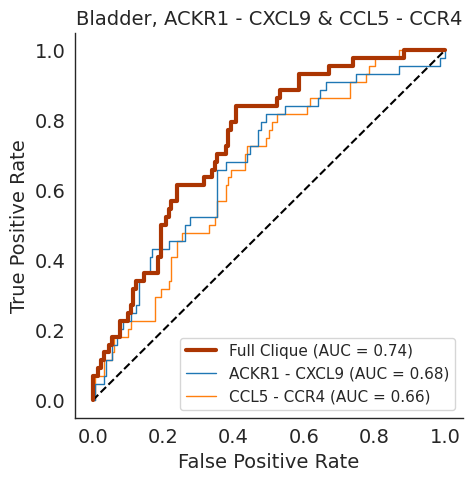

In [61]:

plot_interaction_roc(
    tissue='bladder',
    interaction='ACKR1+CXCL9&CCL5+CCR4',
    crosstalkdf=crosstalkdf_with_orig_name,
    parentdir='/home/lnemati/pathway_crosstalk/results/immunotherapy/individual_interactions_and_motifs',
)



# Processes Enrichment

In [33]:
## Read the results
parentdir = '/home/lnemati/pathway_crosstalk/results/immunotherapy/individual_interactions_and_motifs'

dfs = []

for tissue in os.listdir(parentdir):
    #if tissue in ['full_dataset']: # add back lymph and ureter when they finish running
    #    continue
    path = os.path.join(parentdir, tissue, 'aggregated', 'aggregated.csv')
    tissuedf = pd.read_csv(os.path.join(path))
    tissuedf = tissuedf.rename(columns={'Unnamed: 0': 'interaction'})
    #tissuedf['motif'] = tissuedf['motif'].replace({'3_clique': 'cliques', '4_clique': 'cliques'})

    dfs.append(tissuedf)
        
crosstalkdf = pd.concat(dfs, ignore_index=True)
#crosstalkdf = crosstalkdf.dropna()

crosstalkdf = crosstalkdf.sort_values(by='auroc')[::-1]
crosstalkdf = crosstalkdf.query('motif in ["3_clique", "4_clique"]')
#crosstalkdf = crosstalkdf.query('tissue != "full_dataset"')

better_idx = crosstalkdf.query('auroc > auroc1 and auroc > auroc2').query('auprc > auprc1 and auprc > auprc2').index
crosstalkdf['better'] = False
crosstalkdf.loc[better.index, 'better'] = True

crosstalkdf['interaction'] = crosstalkdf.interaction.str.replace('_', ' - ').str.replace('+', ' - ').str.replace('&', ' & ')

# Split interactions into individual genes for each side
crosstalkdf['interaction1'] = crosstalkdf.interaction.apply(lambda x: re.split('&', x)[0].strip().split(' - '))
crosstalkdf['interaction2'] = crosstalkdf.interaction.apply(lambda x: re.split('&', x)[1].strip().split(' - '))

# Load hallmark gene sets
def read_gmt(file_path):
    gene_sets = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:
                gene_sets[parts[0]] = set(parts[2:])
    return gene_sets

hallmarks_path = '/home/lnemati/resources/msigdb_hallmarks/h.all.v2024.1.Hs.symbols.gmt'
hallmarks = read_gmt(hallmarks_path)

# Generate cleaned hallmark labels
labels = [label.replace('HALLMARK_', '').replace('_', ' ').title() for label in hallmarks.keys()]

replace = {
    'Myc': 'MYC',
    'Kras': 'KRAS',
    'Il2': 'IL2',
    'Stat5': 'STAT5',
    'Il6': 'IL6',
    'Jak': 'JAK',
    'Stat3': 'STAT3',
    'P53': 'P53',
    'Tnfa': 'TNFα',
    'Nfkb': 'NF-κB',
    'Mtorc1': 'mTORC1',
    'Mtorc': 'mTORC',
    'Mtor': 'mTOR',
    ' Dn': ' Down',
    'Pi3K': 'PI3K',
    ' Akt': ' AKT',
    'Epithelial Mesenchymal Transition': 'E-M Transition'
}

for str1, str2 in replace.items():
    labels = [label.replace(str1, str2) for label in labels]

hallmark_name_map = dict(zip(hallmarks.keys(), labels))

# Function to find matching hallmark sets for a given gene list
def find_matching_hallmarks(gene_list, hallmark_sets):
    return [name for name, genes in hallmark_sets.items() if set(gene_list) & genes]

# Get hallmarks for each side of the interaction
crosstalkdf['hallmarks1'] = crosstalkdf['interaction1'].apply(lambda genes: find_matching_hallmarks(genes, hallmarks))
crosstalkdf['hallmarks2'] = crosstalkdf['interaction2'].apply(lambda genes: find_matching_hallmarks(genes, hallmarks))

# Convert to readable labels using the name map
crosstalkdf['hallmarks1'] = crosstalkdf['hallmarks1'].apply(lambda hlist: [hallmark_name_map[h] for h in hlist])
crosstalkdf['hallmarks2'] = crosstalkdf['hallmarks2'].apply(lambda hlist: [hallmark_name_map[h] for h in hlist])

all_hallmarks = list(set(sum(crosstalkdf['hallmarks1'], [])) | set(sum(crosstalkdf['hallmarks2'], [])))

In [34]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------------
# 1.  Build once: boolean membership matrix  (rows × hallmarks)
# ------------------------------------------------------------------
def _build_membership_matrix(crosstalkdf, all_hallmarks):
    """Return:
        - M : (n_rows, n_hallmarks) bool array.  M[i, j] = True
              iff hallmark j is present in row i (either side).
        - row_order_df : original dataframe with a guaranteed
              contiguous integer index (needed for fast boolean masking)
    """
    df = crosstalkdf.reset_index(drop=True)      # contiguous idx
    h_to_col = {h: j for j, h in enumerate(all_hallmarks)}

    # preallocate & fill
    M = np.zeros((len(df), len(all_hallmarks)), dtype=bool)
    for i, (h1, h2) in enumerate(zip(df['hallmarks1'], df['hallmarks2'])):
        for h in set(h1) | set(h2):
            j = h_to_col.get(h)
            if j is not None:
                M[i, j] = True
    return M, df


# ------------------------------------------------------------------
# 2.  Fast hallmark analysis (real or permuted)
# ------------------------------------------------------------------
def _summarise(M, better_mask, all_hallmarks):
    """Vectorised counts & probs for the rows where better_mask is True."""
    idx = better_mask.values if isinstance(better_mask, pd.Series) else better_mask
    sel = M[idx]                       # sub-matrix of True 'better' rows
    counts = sel.sum(axis=0)           # -> (n_hallmarks,) int
    probs  = counts / idx.sum()        # -> float division; broadcast
    return pd.DataFrame({
        'hallmark': all_hallmarks,
        'counts'  : counts,
        'probs'   : probs,
    }).sort_values(by='counts', ascending=False)


# ------------------------------------------------------------------
# 3.  Driver: real data + permutations
# ------------------------------------------------------------------
def analyze_hallmarks_fast(crosstalkdf, all_hallmarks, n_perms=1000, random_state=None):
    rng = np.random.default_rng(random_state)

    # One-time work ────────────────────────────────────────────────
    M, df = _build_membership_matrix(crosstalkdf, all_hallmarks)
    better = df['better'].to_numpy()

    # Real values
    real_summary = _summarise(M, better, all_hallmarks)

    # Permutations
    permuted_summaries = []
    for _ in range(n_perms):
        shuffled = rng.permutation(better)
        permuted_summaries.append(_summarise(M, shuffled, all_hallmarks))

    permuted_summary = pd.concat(permuted_summaries, ignore_index=True)

    return real_summary, permuted_summary

real_values, permuted_values = analyze_hallmarks_fast(
    crosstalkdf,
    all_hallmarks,
    n_perms=5000
)

real_values = real_values.set_index('hallmark')


In [35]:
# Get p-values by counting how often the deviation of permuted values from the mean of the counts is greater than the real one
def get_p_values(real_values, permuted_values):
    """Calculate p-values for real values based on permuted distributions."""
    p_values = {}
    for hallmark in real_values.index:
        real_count = real_values.loc[hallmark, 'counts']
        permuted_counts = permuted_values[permuted_values['hallmark'] == hallmark]['counts']
        mean = permuted_counts.mean()
        real_deviation = np.abs(real_count - mean)
        permuted_deviations = np.abs(permuted_counts - mean)
        p_value = (permuted_deviations >= real_deviation).mean()
        p_values[hallmark] = p_value
    return pd.Series(p_values, name='p_value')

p_values = get_p_values(real_values, permuted_values)
pvals_adj = pd.Series(false_discovery_control(p_values), index=p_values.index)
    

In [36]:
means = permuted_values.groupby('hallmark')['counts'].mean()
stds = permuted_values.groupby('hallmark')['counts'].std()

# get z-scores
hm_z_scores = (real_values['counts'] - means) / stds
hm_z_scores = hm_z_scores.sort_values(ascending=False)
pvals_adj = pvals_adj.loc[hm_z_scores.index]    

# subset to only significant hallmarks
hm_z_scores = hm_z_scores[pvals_adj < 0.05]
pvals_adj = pvals_adj[pvals_adj < 0.05]

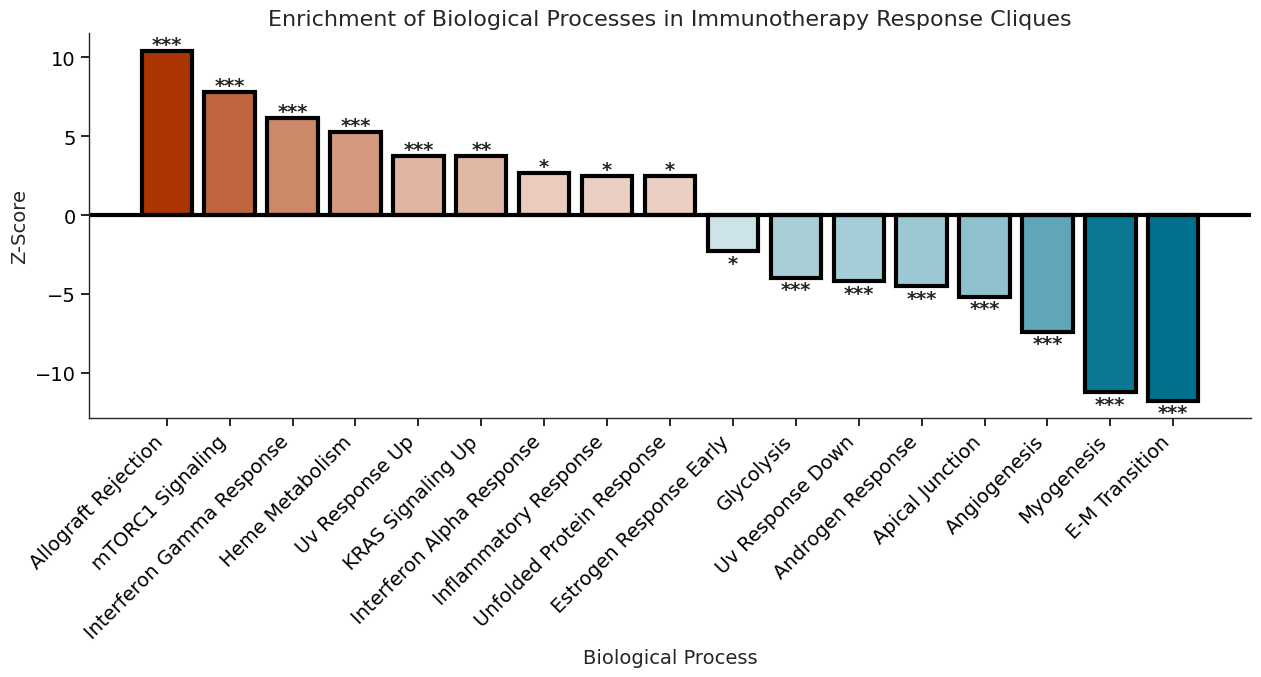

In [37]:
import matplotlib.colors as mcolors

fs = 14

# custom colormap goes from tcolor for max, to white for 0, to ncolor for min
# Create the custom colormap and normalize the z-scores
cmap = mcolors.LinearSegmentedColormap.from_list('custom_gradient', [ncolor, 'white', tcolor])
norm = mcolors.TwoSlopeNorm(vmin=hm_z_scores.min(), vcenter=0, vmax=hm_z_scores.max())
colors = cmap(norm(hm_z_scores))

fig, ax = plt.subplots(figsize=(15, 5))

bars = ax.bar(
    hm_z_scores.index,       # x values (motifs)
    hm_z_scores,     # y values (z-scores)
    color=colors, # Assign the calculated colors
    edgecolor='k',
    linewidth=3,
)

# Rotate x labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=fs)

# Add a horizontal line at y=0
xlim = ax.get_xlim()
ax.hlines(0, xlim[0], xlim[1], color='k', linestyle='-', linewidth=3)
ax.set_xlim(xlim[0], xlim[1])

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)

# Customize the plot
ax.set_title("Enrichment of Biological Processes in Immunotherapy Response Cliques", fontsize=16)
ax.set_xlabel("Biological Process", fontsize=fs)
ax.set_ylabel("Z-Score", fontsize=fs)

# Define significance thresholds
sig_levels = {0.001: '***', 0.01: '**', 0.05: '*'}

# Loop through bars to annotate significance
for bar, z_score, p_val in zip(bars, hm_z_scores, pvals_adj):
    height = bar.get_height()
    sig_symbol = next((symbol for threshold, symbol in sig_levels.items() if p_val <= threshold), None)
    
    if sig_symbol:
        text_y = height + 0.4 if z_score > 0 else height - 0.15  # Adjust position based on sign
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
            text_y,  # Y position
            sig_symbol,
            ha='center',
            va='center' if z_score > 0 else 'top',  # Adjust vertical alignment
            fontsize=fs,
            fontweight='bold'
        )

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)

ax.tick_params(
    axis='both',
    which='both',
    labelsize=fs,
    direction='out',
    length=6,
    width=1.2,
    colors='black'
)

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/hallmarks_z_scores.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/hallmarks_z_scores.png', bbox_inches='tight', dpi=300)

plt.show()


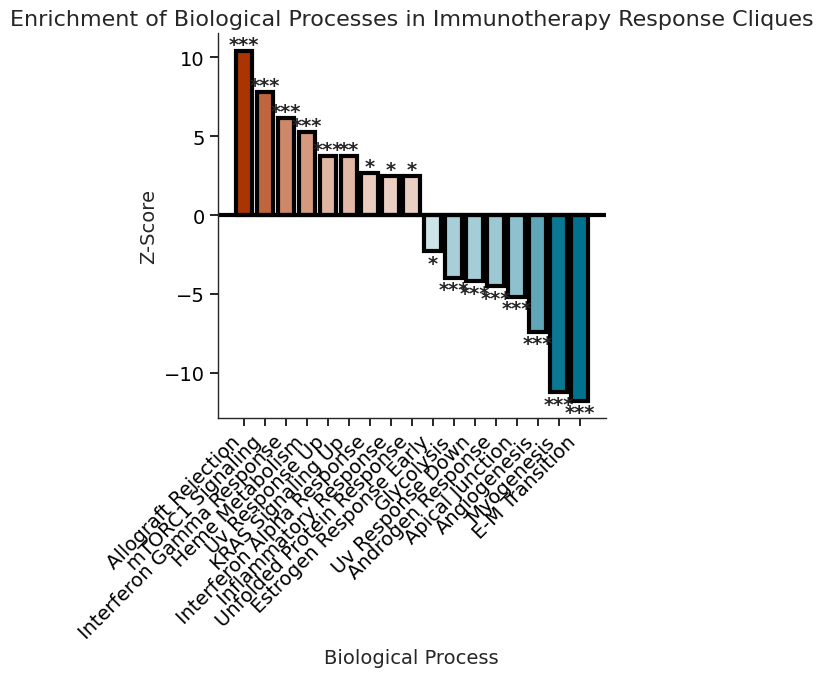

In [38]:
import matplotlib.colors as mcolors

fs = 14

# custom colormap goes from tcolor for max, to white for 0, to ncolor for min
# Create the custom colormap and normalize the z-scores
cmap = mcolors.LinearSegmentedColormap.from_list('custom_gradient', [ncolor, 'white', tcolor])
norm = mcolors.TwoSlopeNorm(vmin=hm_z_scores.min(), vcenter=0, vmax=hm_z_scores.max())
colors = cmap(norm(hm_z_scores))

fig, ax = plt.subplots(figsize=(5, 5))

bars = ax.bar(
    hm_z_scores.index,       # x values (motifs)
    hm_z_scores,     # y values (z-scores)
    color=colors, # Assign the calculated colors
    edgecolor='k',
    linewidth=3,
)

# Rotate x labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=fs)

# Add a horizontal line at y=0
xlim = ax.get_xlim()
ax.hlines(0, xlim[0], xlim[1], color='k', linestyle='-', linewidth=3)
ax.set_xlim(xlim[0], xlim[1])

ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)

# Customize the plot
ax.set_title("Enrichment of Biological Processes in Immunotherapy Response Cliques", fontsize=16)
ax.set_xlabel("Biological Process", fontsize=fs)
ax.set_ylabel("Z-Score", fontsize=fs)

# Define significance thresholds
sig_levels = {0.001: '***', 0.01: '**', 0.05: '*'}

# Loop through bars to annotate significance
for bar, z_score, p_val in zip(bars, hm_z_scores, pvals_adj):
    height = bar.get_height()
    sig_symbol = next((symbol for threshold, symbol in sig_levels.items() if p_val <= threshold), None)
    
    if sig_symbol:
        text_y = height + 0.4 if z_score > 0 else height - 0.15  # Adjust position based on sign
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # X position (center of bar)
            text_y,  # Y position
            sig_symbol,
            ha='center',
            va='center' if z_score > 0 else 'top',  # Adjust vertical alignment
            fontsize=fs,
            fontweight='bold'
        )

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)

ax.tick_params(
    axis='both',
    which='both',
    labelsize=fs,
    direction='out',
    length=6,
    width=1.2,
    colors='black'
)

plt.show()


In [39]:
crosstalkdf[crosstalkdf.interaction.str.startswith('ACKR1 - CXCL9 & CCL5 - CCR4')]

interaction     auroc    auroc1    auroc2     auprc  \
28590   ACKR1 - CXCL9 & CCL5 - CCR4       NaN  0.464336       NaN       NaN   
90928   ACKR1 - CXCL9 & CCL5 - CCR4  0.763889  0.736111  0.680556  0.451923   
108529  ACKR1 - CXCL9 & CCL5 - CCR4  0.747368  0.778947  0.747368  0.433584   
59386   ACKR1 - CXCL9 & CCL5 - CCR4  0.738287  0.679021  0.659965  0.478352   
126871  ACKR1 - CXCL9 & CCL5 - CCR4  0.684211  0.670844  0.707602  0.499765   
46311   ACKR1 - CXCL9 & CCL5 - CCR4  0.678571  0.666667  0.619048  0.409484   
7675    ACKR1 - CXCL9 & CCL5 - CCR4  0.670202  0.667522  0.654952  0.431908   
86142   ACKR1 - CXCL9 & CCL5 - CCR4  0.614664  0.549830  0.626002  0.491705   
32947   ACKR1 - CXCL9 & CCL5 - CCR4  0.533469  0.419878  0.541582  0.456016   

          auprc1    auprc2  auroc_diff  auprc_diff     motif  \
28590   0.154204       NaN         NaN         NaN  4_clique   
90928   0.417157  0.287500    0.027778    0.034766  4_clique   
108529  0.505965  0.505556   -0.031579   -0.072381  4_clique   
59386   0.400603  0.382915    0.059266    0.077749  4_clique   
126871  0.569271  0.452939   -0.023392   -0.069506  4_clique   
46311   0.431095  0.327036    0.011905   -0.021611  4_clique   
7675    0.417712  0.394527    0.002680    0.014197  4_clique   
86142   0.405424  0.481822   -0.011338    0.009884  4_clique   
32947   0.342076  0.510234   -0.008114   -0.054218  4_clique   

                  tissue  better    interaction1  interaction2  \
28590             kidney   False  [ACKR1, CXCL9]  [CCL5, CCR4]   
90928   lymphatic_tissue    True  [ACKR1, CXCL9]  [CCL5, CCR4]   
108529            ureter   False  [ACKR1, CXCL9]  [CCL5, CCR4]   
59386            bladder    True  [ACKR1, CXCL9]  [CCL5, CCR4]   
126871           stomach   False  [ACKR1, CXCL9]  [CCL5, CCR4]   
46311               lung   False  [ACKR1, CXCL9]  [CCL5, CCR4]   
7675        full_dataset    True  [ACKR1, CXCL9]  [CCL5, CCR4]   
86142               skin   False  [ACKR1, CXCL9]  [CCL5, CCR4]   
32947              brain   False  [ACKR1, CXCL9]  [CCL5, CCR4]   

                                               hallmarks1  \
28590   [Allograft Rejection, Heme Metabolism, IL6 JAK...   
90928   [Allograft Rejection, Heme Metabolism, IL6 JAK...   
108529  [Allograft Rejection, Heme Metabolism, IL6 JAK...   
59386   [Allograft Rejection, Heme Metabolism, IL6 JAK...   
126871  [Allograft Rejection, Heme Metabolism, IL6 JAK...   
46311   [Allograft Rejection, Heme Metabolism, IL6 JAK...   
7675    [Allograft Rejection, Heme Metabolism, IL6 JAK...   
86142   [Allograft Rejection, Heme Metabolism, IL6 JAK...   
32947   [Allograft Rejection, Heme Metabolism, IL6 JAK...   

                                               hallmarks2  
28590   [Allograft Rejection, Complement, IL2 STAT5 Si...  
90928   [Allograft Rejection, Complement, IL2 STAT5 Si...  
108529  [Allograft Rejection, Complement, IL2 STAT5 Si...  
59386   [Allograft Rejection, Complement, IL2 STAT5 Si...  
126871  [Allograft Rejection, Complement, IL2 STAT5 Si...  
46311   [Allograft Rejection, Complement, IL2 STAT5 Si...  
7675    [Allograft Rejection, Complement, IL2 STAT5 Si...  
86142   [Allograft Rejection, Complement, IL2 STAT5 Si...  
32947   [Allograft Rejection, Complement, IL2 STAT5 Si...

# Save predictions

In [105]:
paths = [
'./full_dataset/prediction_probabilities/all_cliques.csv',
'./kidney/prediction_probabilities/all_cliques.csv',
'./brain/prediction_probabilities/all_cliques.csv',
'./lung/prediction_probabilities/all_cliques.csv',
'./bladder/prediction_probabilities/all_cliques.csv',
'./skin/prediction_probabilities/all_cliques.csv',
'./lymphatic_tissue/prediction_probabilities/all_cliques.csv',
'./ureter/prediction_probabilities/all_cliques.csv',
'./stomach/prediction_probabilities/all_cliques.csv',
]

In [140]:
merged = []

for tissue in os.listdir('/home/lnemati/pathway_crosstalk/results/immunotherapy/features_sets/tissues'):
    print(tissue)
    path = os.path.join('/home/lnemati/pathway_crosstalk/results/immunotherapy/features_sets/tissues', tissue, 'prediction_probabilities')
    # list files
    for i, file in enumerate(os.listdir(path)):
        if i == 0:
            results = pd.read_csv(os.path.join(path, file), index_col=0).T
        else:
            probs = pd.read_csv(os.path.join(path, file), index_col=0)
            probs = probs.T.drop(columns=['target'])
            results = results.join(probs, how='outer')

    # insert cohort as first column
    results.insert(0, 'cohort', tissue)
    merged.append(results)

merged = pd.concat(merged)[::-1]

merged.to_csv('/home/lnemati/pathway_crosstalk/results/immunotherapy/features_sets/merged_prediction_probabilities.csv')

full_dataset
kidney
brain
lung
bladder
skin
lymphatic_tissue
ureter
stomach


In [139]:
merged

cohort target           all_cliques         tls-melanoma  \
ERR3640832       stomach      R    0.8190733194351196   0.5439995527267456   
ERR3640831       stomach      R    0.5822492241859436   0.5196115374565125   
ERR3640830       stomach      N  0.054617103189229965  0.42107418179512024   
ERR3640829       stomach      N    0.4464458227157593   0.5260854959487915   
ERR3640828       stomach      R    0.6186704039573669   0.5174582600593567   
...                  ...    ...                   ...                  ...   
EA595522    full_dataset      N   0.29200345277786255  0.34315502643585205   
EA595500    full_dataset      N    0.2384379506111145    0.308633953332901   
EA595473    full_dataset      R   0.21560993790626526   0.2936337888240814   
EA595455    full_dataset      N   0.23956815898418427  0.28470322489738464   
EA595454    full_dataset      N   0.20925043523311615   0.2927318811416626   

                       mdsc_pca             all_ccis                 ifng  \
ERR3640832   0.5563820004463196   0.5160784125328064   0.4297547936439514   
ERR3640831    0.604193925857544   0.5082955360412598    0.340505450963974   
ERR3640830   0.5484359264373779   0.4508569836616516   0.4236890375614166   
ERR3640829   0.2057969868183136   0.3754417300224304  0.49964219331741333   
ERR3640828   0.5556356310844421   0.4635477364063263   0.3993372321128845   
...                         ...                  ...                  ...   
EA595522     0.1997072398662567  0.24510806798934937    0.302200049161911   
EA595500    0.43235382437705994  0.19584864377975464  0.24449607729911804   
EA595473     0.3712036907672882    0.210637629032135   0.2909086346626282   
EA595455    0.27974966168403625  0.22089147567749023    0.331452339887619   
EA595454     0.5145565867424011   0.3324284255504608   0.3331882655620575   

                          cd274 t_cell_exclusion_pca                  cd8  \
ERR3640832  0.42925867438316345   0.5501119494438171   0.6557608842849731   
ERR3640831  0.26576128602027893   0.6044110059738159   0.3985828757286072   
ERR3640830   0.3777432143688202   0.4443630576133728  0.05410217493772507   
ERR3640829   0.2286374717950821   0.3299580216407776  0.42535626888275146   
ERR3640828  0.48291105031967163  0.46730533242225647   0.6119773983955383   
...                         ...                  ...                  ...   
EA595522                    NaN   0.3533194363117218  0.32189232110977173   
EA595500                    NaN  0.49164313077926636  0.33903637528419495   
EA595473                    NaN   0.5770817995071411   0.3151884377002716   
EA595455                    NaN   0.4214877486228943   0.3207913339138031   
EA595454                    NaN   0.5683093667030334  0.32386717200279236   

            t_cell-inflamed_gep t_cell_dysfunction_pca           tam_m2_pca  \
ERR3640832   0.5422836542129517     0.5389212369918823   0.5182608366012573   
ERR3640831  0.36897820234298706     0.5972604751586914   0.5529058575630188   
ERR3640830   0.2409924566745758      0.389923095703125   0.4115569293498993   
ERR3640829    0.380504310131073    0.21994657814502716  0.34596043825149536   
ERR3640828   0.4500093460083008     0.5565095543861389   0.5523287057876587   
...                         ...                    ...                  ...   
EA595522    0.30523431301116943     0.2160109132528305  0.21813146770000458   
EA595500    0.30372610688209534    0.45973771810531616  0.30487340688705444   
EA595473     0.2921575903892517     0.2538090944290161    0.291467547416687   
EA595455     0.2945556938648224    0.28336647152900696   0.7210696935653687   
EA595454    0.30613645911216736     0.4742204248905182   0.4071305990219116   

                            tls  whole_transcriptome              caf_pca  
ERR3640832   0.6150450110435486   0.5119113922119141   0.5187798738479614  
ERR3640831   0.6930002570152283   0.5322537422180176    0.583698034286499  
ERR3640830  0.15750516951084137  0.41770580410957336  

# Full Figure

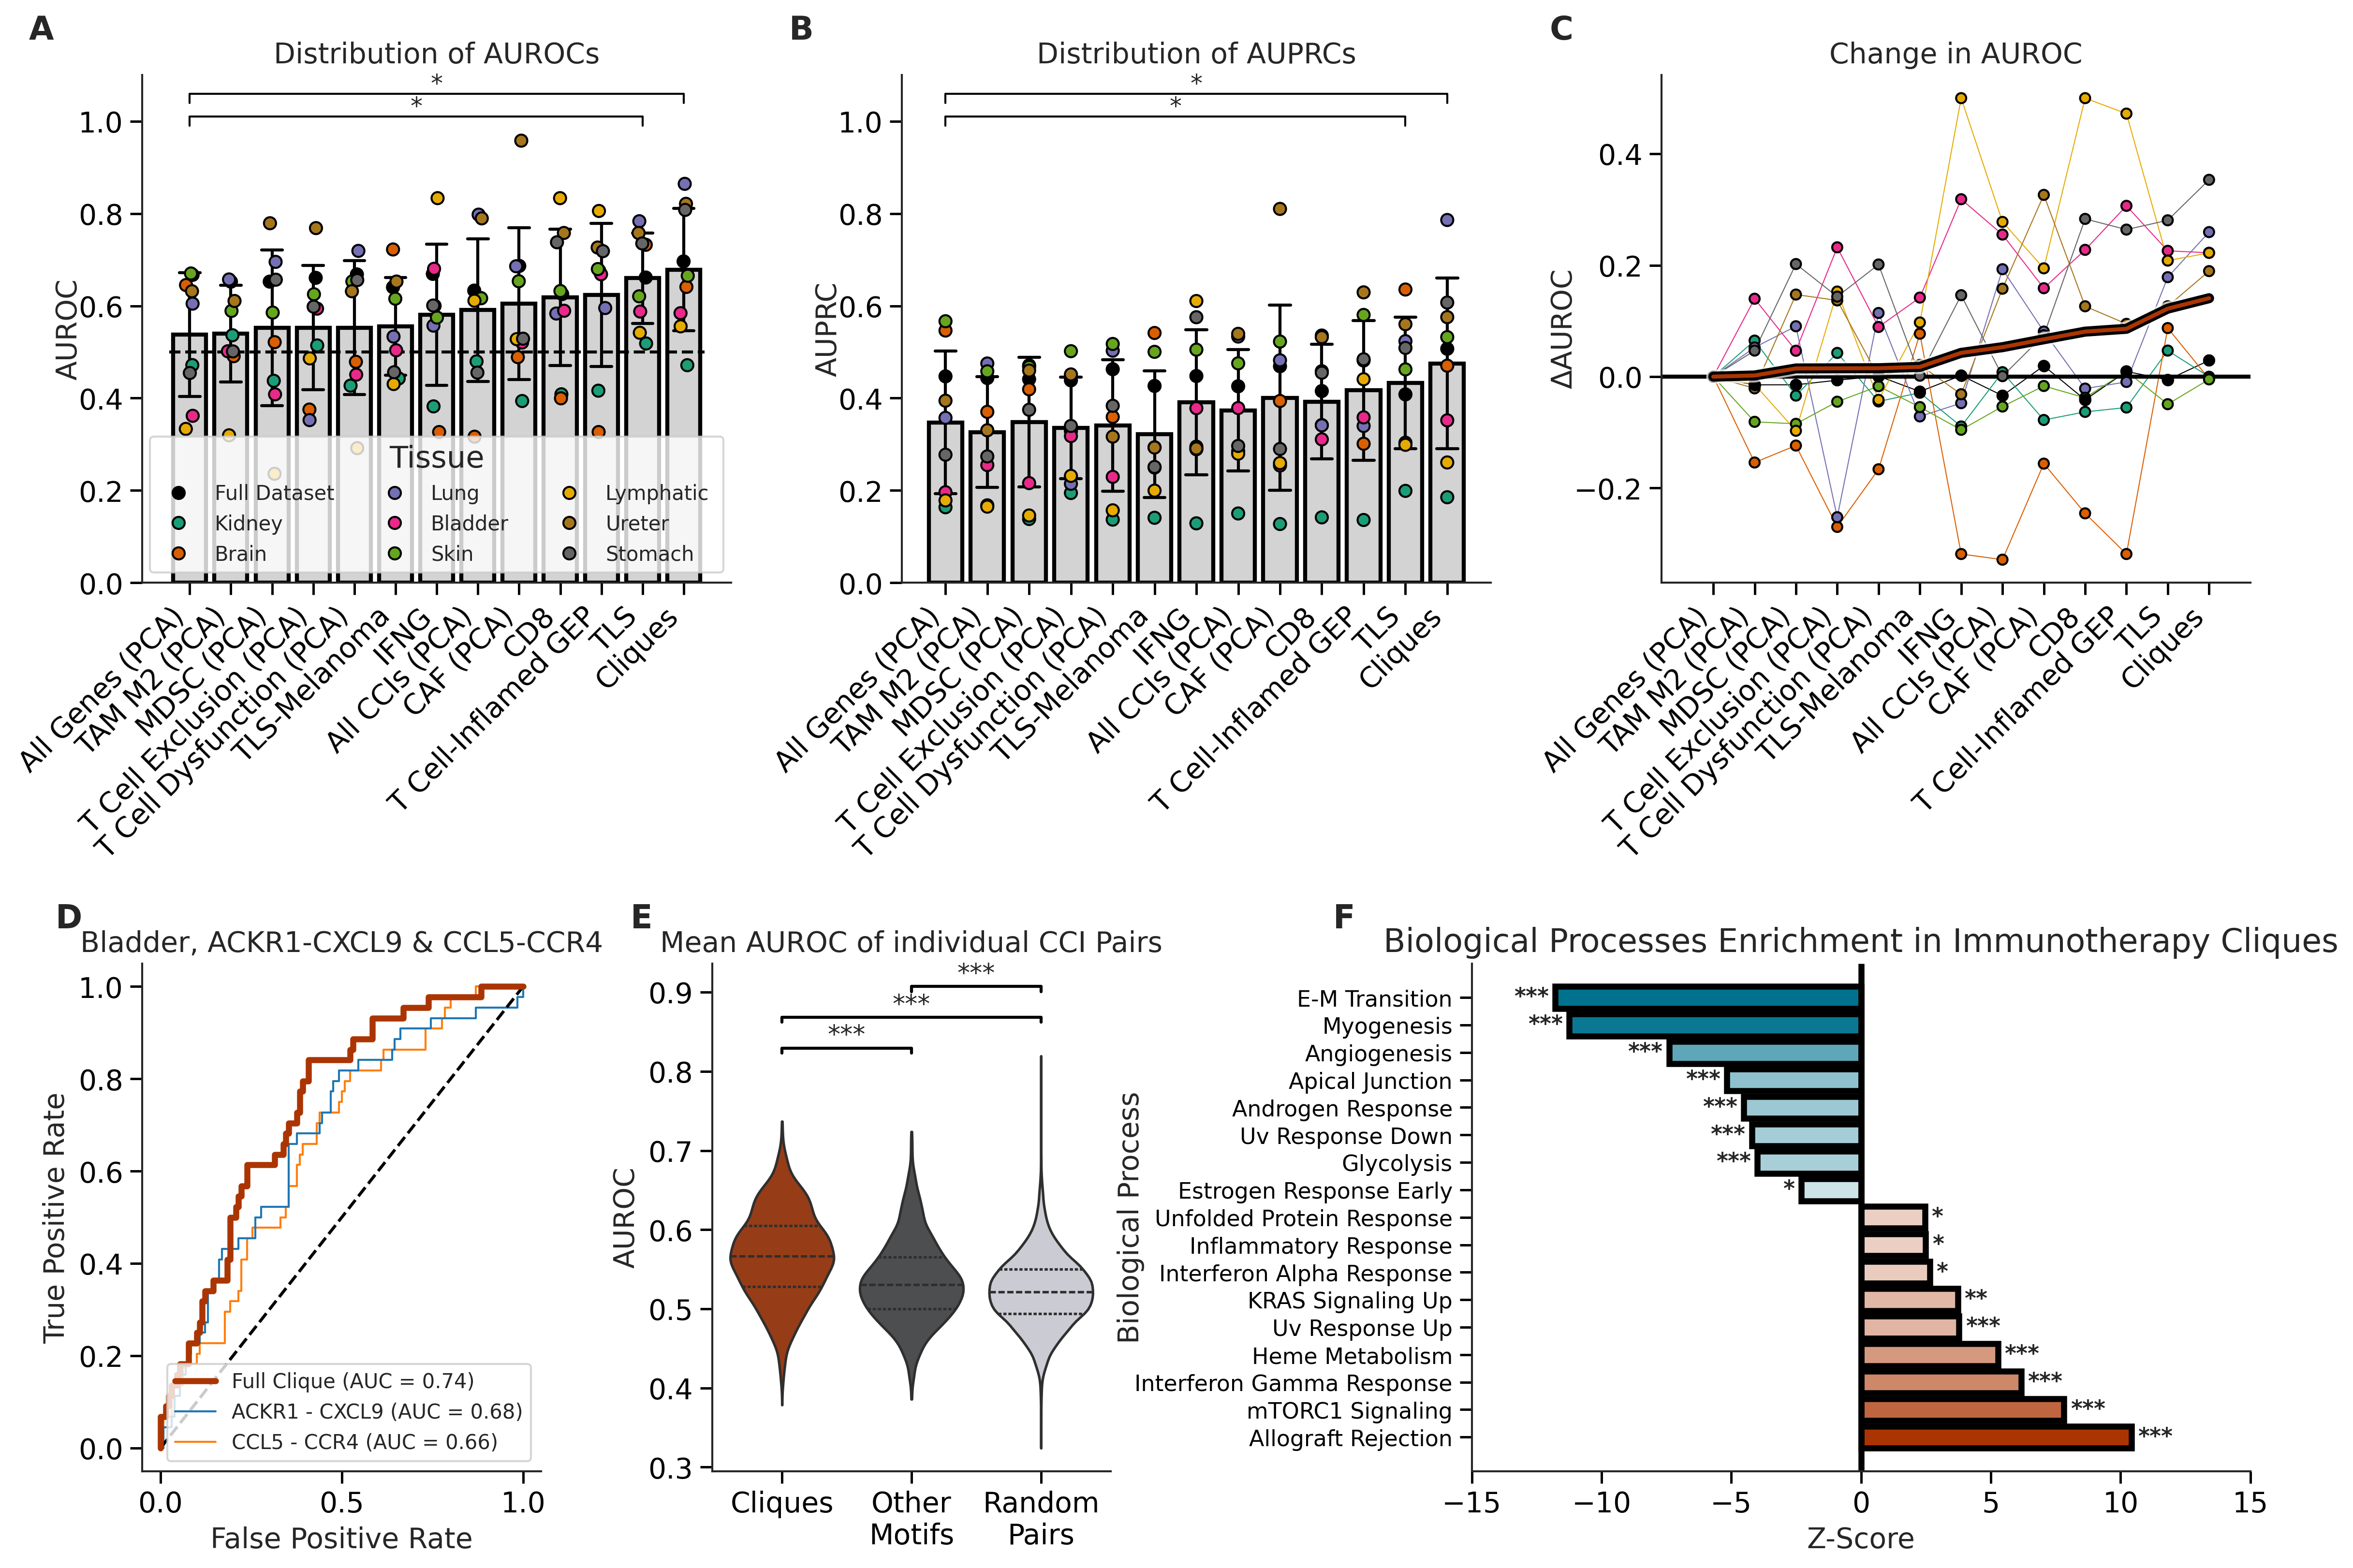

In [85]:
from scipy.stats import ks_2samp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

fs = 14
smallfs = 11

unit = 6.25 # size of a panel

# Create figure
fig, axes = plt.subplot_mosaic(
    mosaic="""
    AAAABBBBCCCC
    DDDEEEXFFFFF
    """,
    figsize=(3*unit, 2*unit),
    #constrained_layout=True,
    dpi=300,
)
fig.subplots_adjust(hspace=0.75, wspace=9)

########### PANEL A: AUROC barplots
ax1 = axes['A']
ax2 = axes['B']

sns.barplot(
    data=metricsdf,
    x='type',
    y='auroc',
    estimator='mean',
    ci='sd',
    color='lightgray',
    ax=ax1,
    order=order,
    errcolor='black',
    errwidth=1.5,
    capsize=0.5,
    lw=2,
    edgecolor='k',
)
sns.stripplot(metricsdf, x='type', y='auroc', hue='cohort', palette=cohort_colors, jitter=True, size=6, edgecolor="black", linewidth=1., ax=ax1, order=order)

ax1.hlines(0.5, *ax1.get_xlim(), color='k', linestyle='--')
#ax1.set_xlabel("Features Set", fontsize=fs)
ax1.set_ylabel("AUROC", fontsize=fs)
ax1.set_title('Distribution of AUROCs', fontsize=fs)


# AUPRC
#sns.boxplot(metricsdf.query('cohort != "full_dataset"'), x='type', y='auprc', color='lightgray', boxprops={"alpha": 0.7}, ax=ax2, order=order)

sns.barplot(
    data=metricsdf,
    x='type',
    y='auprc',
    estimator='mean',
    ci='sd',
    color='lightgray',
    ax=ax2,
    order=order,
    errcolor='black',
    errwidth=1.5,
    capsize=0.5,
    lw=2,
    edgecolor='k',
)
sns.stripplot(metricsdf, x='type', y='auprc', hue='cohort', palette=cohort_colors, jitter=False, size=6, edgecolor="black", linewidth=1., ax=ax2, order=order)

#ax2.set_title("AUPRC", fontsize=fs)
ax2.set_xlabel("Features Set", fontsize=fs)
ax2.set_ylabel("AUPRC", fontsize=fs)
ax2.set_title('Distribution of AUPRCs', fontsize=fs)

ax2.get_legend().remove()

#fig.suptitle('Distribution of AUROCs and AUPRCs Across Features Sets', fontsize=fs, )

# Compute p-values for AUROC and AUPRC separately
p_values_auroc = []
p_values_auprc = []
comparisons = []
reference_group = "whole_transcriptome"

for group in order:
    if group == reference_group:
        continue
    stat_auroc, p_auroc = wilcoxon(df_diff.query(f'type == "{group}"')["auroc_diff"], alternative='greater')
    stat_auprc, p_auprc = wilcoxon(df_diff.query(f'type == "{group}"')["auprc_diff"], alternative='greater')
    
    if p_auroc < 0.05 or p_auprc < 0.05:
        p_values_auroc.append(p_auroc)
        p_values_auprc.append(p_auprc)
        comparisons.append(group)

# Function to convert p-values to significance stars
def get_significance_label(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

pval_labels_auroc = {group: get_significance_label(p) for group, p in zip(comparisons, p_values_auroc)}
pval_labels_auprc = {group: get_significance_label(p) for group, p in zip(comparisons, p_values_auprc)}

ax1.set_ylim(bottom=0, top=1.1)
ax2.set_ylim(bottom=0, top=1.1)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

# Function to add significance bars
def add_significance_bars(ax, pval_labels, comparisons, y_offset=0.05, text_offset=0.02):
    y_max = 0.9*ax.get_ylim()[1]
    bar_height = (y_max - ax.get_ylim()[0]) * 0.02
    
    for i, group in enumerate(comparisons):
        sig_label = pval_labels[group]
        x1, x2 = order.index(reference_group), order.index(group)
        y = y_max + (2.5 * i * bar_height)

        ax.plot([x1, x1, x2, x2], [y, y + bar_height, y + bar_height, y], lw=1, linestyle='-', color="black")
        ax.text(0.5 * (x1 + x2), y + 1.3 * bar_height, sig_label, ha='center', fontsize=12)

# Add significance bars
add_significance_bars(ax1, pval_labels_auroc, comparisons)
add_significance_bars(ax2, pval_labels_auprc, comparisons)

handles, legend_labels = ax1.get_legend_handles_labels()
ax1.legend(
    handles,
    [label.title().replace('_', ' ').replace('Tissue', '') for label in legend_labels],
    title="Tissue",
    ncol=3,
    fontsize=smallfs-1,
    loc='lower center'
)


# Adjust x-labels
for ax in (ax1, ax2):
    ax.set_xticklabels(features_labels, rotation=45, ha='right')
    ax.set_xlabel('')
    ax.tick_params(labelsize=fs)

########### PANEL C: AUROC difference

ax3 = axes['C']

# AUROC Difference subplot (Left)
sns.stripplot(df_diff, x='type', y='auroc_diff', hue=df_diff['cohort'], palette=cohort_colors, 
              jitter=False, size=5, edgecolor="black", linewidth=1., alpha=alpha, ax=ax3, order=order)
sns.stripplot(df_diff.query('cohort == "full_dataset"'), x='type', y='auroc_diff', color='black', 
              jitter=False, size=5, edgecolor="black", linewidth=1., alpha=alpha, ax=ax3, order=order)

for cohort in df_diff.cohort.unique():
    ax3.plot(df_diff.query('cohort == @cohort').set_index('type').reindex(order)['auroc_diff'], 
             color=cohort_colors.get(cohort, 'black'), linestyle='-', alpha=alpha, lw=0.5)

# Mean AUROC difference line
mean_auroc = df_diff.groupby('type')['auroc_diff'].mean().reindex(order)

ax3.plot(
    order,
    mean_auroc,
    color=tcolor,  # This will stay fully visible
    linewidth=2,
    linestyle='-',
    path_effects=[
        pe.Stroke(linewidth=7, foreground='white', alpha=0.7),   # Outer soft white halo
        pe.Stroke(linewidth=5, foreground='black', alpha=1),     # Inner solid black halo
        pe.Normal()                                              # Actual line on top
    ],
    label='Mean',
    zorder=10
)

ax3.set_title('Change in AUROC', fontsize=fs)

#xlim = ax3.get_xlim()
#ax3.hlines(0, *ax3.get_xlim(), color='k', linestyle='-')

xlim = (-1.25, 13)
ax3.hlines(0, xlim[0], xlim[1], color='k', linestyle='-', linewidth=2)
ax3.set_xlim(xlim[0], xlim[1])

ax3.set_ylabel(r"$\Delta$AUROC", fontsize=fs)
ax3.get_legend().remove()
# Translate labels
ax3.set_xticklabels(features_labels, rotation=45, ha='right', fontsize=fs)

# reduce label padding
for ax in (ax1, ax2, ax3):
    #ax.set_xlabel('Features Set', fontsize=fs, labelpad=-10)
    ax.set_xlabel('')
    ax.set_ylabel(ax.get_ylabel(), fontsize=fs, labelpad=-2)


for ax in axes.values():
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    
    ax.tick_params(
        axis='both',
        which='both',
        labelsize=fs,
        direction='out',
        length=6,
        width=1.2,
        colors='black'
    )

########### PANEL D: ROC Curve

ax = axes['D']

plot_interaction_roc(
    tissue='bladder',
    interaction='ACKR1+CXCL9&CCL5+CCR4',
    crosstalkdf=crosstalkdf_with_orig_name,
    parentdir='/home/lnemati/pathway_crosstalk/results/immunotherapy/individual_interactions_and_motifs',
    legendfs=smallfs-1,
    ax=ax,
)

ax.set_title('Bladder, ACKR1-CXCL9 & CCL5-CCR4', fontsize=fs)

################ PANEL E: Violinplot

ax1 = axes['E']

# Plot violinplots with sorted order
sns.violinplot(data=df_mean, y='mean_auroc', x='motif', order=sorted_motifs, palette=palette_sorted, ax=ax1, inner='quart', cut=0)

# Prepare all pairs for comparison
pairs = list(itertools.combinations(sorted_motifs, 2))

# Function to get p-value for pair and metric
def get_pval(group1, group2, metric):
    data1 = df_mean.query(f'motif == "{group1}"')[metric].dropna()
    data2 = df_mean.query(f'motif == "{group2}"')[metric].dropna()
    return mannwhitneyu(data1, data2).pvalue

# Significance label function
def get_sig_label(pval):
    if pval > 0.05:
        return "ns"
    elif pval > 0.01:
        return "*"
    elif pval > 0.001:
        return "**"
    else:
        return "***"
    return

# Function to add significance bars for all pairs
def add_all_significance_bars(ax, metric, y_start=0.05, y_step=0.05, height=0.008):
    ylim = ax.get_ylim()
    y_max = 0.92*ylim[1]
    
    for i, (g1, g2) in enumerate(pairs):
        pval = get_pval(g1, g2, metric)
        x1, x2 = sorted_motifs.index(g1), sorted_motifs.index(g2)
        y = y_max + y_start * y_max + i * y_step * y_max
        
        # Draw bar
        ax.plot([x1, x1, x2, x2], [y, y + height * y_max, y + height * y_max, y], lw=1.5, c='black')
        ax.text((x1 + x2) / 2, y + height * y_max, get_sig_label(pval), ha='center', va='bottom', fontsize=fs*0.9)

# Add significance bars to each plot
add_all_significance_bars(ax1, 'mean_auroc', y_start=0.06)

ax1.set_ylabel('AUROC')
ax1.tick_params(axis='both', labelsize=fs)
ax1.set_xlabel(ax1.get_xlabel().title(), fontsize=fs)
ax1.set_ylabel(ax1.get_ylabel().upper(), fontsize=fs)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
#ax1.set_xticklabels([label.get_text().title().replace('_', ' ') for label in ax1.get_xticklabels()], rotation=45, ha='right')
ax1.set_xticklabels(
    [label.get_text().title().replace('_', ' ').replace(' ', '\n') for label in ax1.get_xticklabels()],
    rotation=0,
    ha='center'
)

ax1.set_title('Mean AUROC of individual CCI Pairs', fontsize=fs)
ax1.set_xlabel('')

################# PANEL F: Enrichment

ax = axes['F']

bars = ax.barh(
    hm_z_scores.index,   # y values (motifs / biological processes)
    hm_z_scores,         # x values (z-scores)
    color=colors,
    edgecolor='k',
    linewidth=3,
)

# Add a vertical line at x=0
ylim = ax.get_ylim()
ax.vlines(0, ylim[0], ylim[1], color='k', linestyle='-', linewidth=3)
ax.set_ylim(ylim[0], ylim[1])

# Style adjustments
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)

# Customize the plot
ax.set_title("Biological Processes Enrichment in Immunotherapy Cliques", fontsize=16)
ax.set_ylabel("Biological Process", fontsize=fs)
ax.set_xlabel("Z-Score", fontsize=fs)

# Define significance thresholds
sig_levels = {0.001: '***', 0.01: '**', 0.05: '*'}

# Annotate significance symbols
for bar, z_score, p_val in zip(bars, hm_z_scores, pvals_adj):
    width = bar.get_width()
    sig_symbol = next((symbol for threshold, symbol in sig_levels.items() if p_val <= threshold), None)
    
    if sig_symbol:
        text_x = width + 0.25 if z_score > 0 else width - 0.25  # Adjust position
        ax.text(
            text_x,                           # X position
            bar.get_y() + bar.get_height()/2, # Y position (center of bar)
            sig_symbol,
            va='center',
            ha='left' if z_score > 0 else 'right',
            fontsize=smallfs,
            fontweight='bold'
        )

# Axis visibility and ticks
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)

# Final tick params
ax.tick_params(
    axis='both',
    which='both',
    labelsize=fs,
    direction='out',
    length=6,
    width=1.2,
    colors='black'
)

# reduce label padding of y-axis
ax.set_ylabel(ax.get_ylabel(), fontsize=fs, labelpad=-5)

ax.set_xlim(-15, 15)

# Optional: Rotate y-axis labels if needed (they're horizontal by default)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=smallfs)

#### AXIS X: blank
#delete everything from ax['X'], leave it completely blank, not even the axis
ax = axes['X']

ax.axis('off')  # Turn off the axis

ax = axes['A']
ax.text(-0.15, 1.12, 'A', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')
ax = axes['B']
ax.text(-0.15, 1.12, 'B', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')
ax = axes['C']
ax.text(-0.15, 1.12, 'C', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')
ax = axes['D']
ax.text(-0.15, 1.12, 'D', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')
ax = axes['E']
ax.text(-0.15, 1.12, 'E', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')
ax = axes['F']
ax.text(-0.15, 1.12, 'F', fontsize=16, fontweight='bold', transform=ax.transAxes, va='top', ha='right')

# SAVE FIG

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig7/fig7.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig7/fig7.svg', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig7/fig7.png', bbox_inches='tight', dpi=300)

plt.show()


In [86]:
fig_to_panels(fig, axes, output_dir='/home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig7/panels')

Saved panel 'Distribution of AUROCs' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig7/panels/distribution_of_aurocs
Saved panel 'Distribution of AUPRCs' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig7/panels/distribution_of_auprcs
Saved panel 'Change in AUROC' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig7/panels/change_in_auroc
Saved panel 'Bladder, ACKR1-CXCL9 & CCL5-CCR4' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig7/panels/bladder,_ackr1-cxcl9_&_ccl5-ccr4
Saved panel 'Mean AUROC of individual CCI Pairs' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig7/panels/mean_auroc_of_individual_cci_pairs
Saved panel '' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib_full_figures/fig7/panels/
Saved panel 'Biological Processes Enrichment in Immunotherapy Cliques' to /home/lnemati/pathway_crosstalk/results/figures/matplotlib

In [126]:
enrichment_df

hallmark          pval  odds_ratio  better_prob  \
1                 Allograft Rejection  1.980898e-16    1.263694     0.830833   
26          Interferon Gamma Response  4.551307e-06    1.106263     0.482058   
24              Inflammatory Response  6.554714e-02    1.041604     0.466110   
44           TNFα Signaling Via NF-κB  1.512376e-01    1.032744     0.406588   
4                     Apical Junction  8.693412e-05    0.915568     0.391114   
23            IL6 JAK STAT3 Signaling  3.943172e-01    1.019953     0.354566   
22                IL2 STAT5 Signaling  6.658823e-01    0.989909     0.329694   
28                  KRAS Signaling Up  4.597943e-03    1.073601     0.266376   
13  Epithelial Mesenchymal Transition  1.508341e-19    0.797072     0.243212   
25          Interferon Alpha Response  4.550945e-02    1.057414     0.197551   
33                         Myogenesis  5.974684e-18    0.792115     0.195367   
10                         Complement  8.398626e-01    1.005991     0.176476   
47                     Uv Response Up  4.555411e-03    1.101603     0.121701   
9                         Coagulation  8.464350e-01    1.006786     0.109835   
27                KRAS Signaling Down  6.339884e-01    1.017245     0.101196   
30                   mTORC1 Signaling  5.848874e-09    1.258720     0.091798   
6                           Apoptosis  9.502484e-01    0.996941     0.075280   
20                    Heme Metabolism  1.087213e-04    1.186905     0.070344   
46                   Uv Response Down  1.224158e-03    0.867919     0.064743   
21                            Hypoxia  1.000000e+00    1.000191     0.044143   
0                        Adipogenesis  8.213362e-02    0.909554     0.042434   
36                        P53 Pathway  2.091130e-01    0.933127     0.041959   
3                        Angiogenesis  4.064135e-09    0.730271     0.039586   
39            PI3K AKT mTOR Signaling  2.464231e-01    0.932814     0.035409   
2                   Androgen Response  3.485034e-04    0.792327     0.027435   
49              Xenobiotic Metabolism  9.193326e-01    1.006141     0.027340   
5                      Apical Surface  6.779273e-01    0.969846     0.025252   
7                Bile Acid Metabolism  1.005938e-01    1.128072     0.024302   
14            Estrogen Response Early  8.239531e-02    0.883797     0.024302   
15             Estrogen Response Late  8.725613e-02    0.884426     0.024112   
18                         Glycolysis  2.159823e-03    0.802697     0.022499   
45          Unfolded Protein Response  7.277252e-02    1.178623     0.015569   
19                 Hedgehog Signaling  7.155490e-01    0.963701     0.014335   
37                Pancreas Beta Cells  6.673099e-01    1.044886     0.010917   
43                 Tgf Beta Signaling  7.101590e-01    0.956018     0.010442   
34                    Notch Signaling  1.499924e-01    0.835981     0.007974   
8             Cholesterol Homeostasis  3.789921e-01    0.855672     0.004177   
16              Fatty Acid Metabolism  5.200695e-01    1.152173     0.002943   
40                  Protein Secretion  2.627428e-01    0.742560     0.001899   
17                     G2M Checkpoint  7.417008e-01    0.817180     0.000949   
32                     MYC Targets V2  2.175594e-01    0.612684     0.000854   
48         Wnt Beta Catenin Signaling  5.469321e-01    1.226223     0.000854   
38                         Peroxisome  2.175594e-01    0.612684     0.000854   
12                        E2F Targets  1.000000e+00         NaN     0.000000   
41    Reactive Oxygen Species Pathway  1.000000e+00         NaN     0.000000   
11                         Dna Repair  1.000000e+00         NaN     0.000000   
42                    Spermatogenesis  1.000000e+00         NaN     0.000000   
29                    Mitotic Spindle  1.000000e+00         NaN     0.000000   
31                     MYC Targets V1  1.000000e+00         NaN     0.000000   
35          Oxidative Phospho

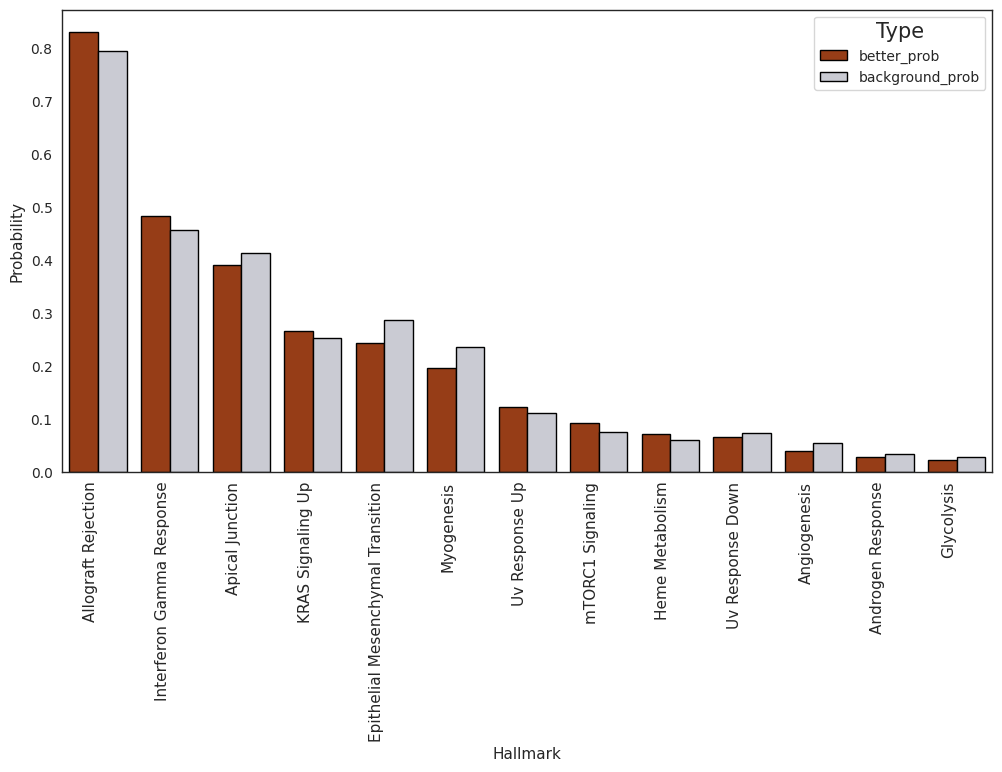

In [ ]:
from scipy.stats import fisher_exact

# Create background set
all_interactions = crosstalkdf.copy()
all_interactions['hallmarks'] = all_interactions['hallmarks1'] + all_interactions['hallmarks2']
better['hallmarks'] = better['hallmarks1'] + better['hallmarks2']

results = []
for hm in labels:
    a = better['hallmarks'].apply(lambda x: hm in x).sum()
    b = better.shape[0] - a
    c = all_interactions['hallmarks'].apply(lambda x: hm in x).sum()
    d = all_interactions.shape[0] - c
    # Perform Fisher's exact test
    odds_ratio, p = fisher_exact([[a, b], [c, d]])
    better_prob = a / better.shape[0] if better.shape[0] else 0
    background_prob = c / all_interactions.shape[0] if all_interactions.shape[0] else 0
    results.append({
        'hallmark': hm,
        'pval': p,
        'odds_ratio': odds_ratio,
        'better_prob': better_prob,
        'background_prob': background_prob,
    })

enrichment_df = pd.DataFrame(results).sort_values('better_prob', ascending=False)
#enrichment_df = enrichment_df.dropna()

# multiple hypothesis correction
enrichment_df['pval_adj'] = false_discovery_control(enrichment_df['pval'])

# log odds ratio
enrichment_df['log_odds_ratio'] = np.log2(enrichment_df['odds_ratio'])

# Plot
plt.figure(figsize=(12, 6))
# barplot of better vs background probabilities
#sns.barplot(data=enrichment_df, x='hallmark', y='better_prob', color=tcolor, edgecolor='k', label='Better')
#sns.barplot(data=enrichment_df, x='hallmark', y='background_prob', color=lightgray, edgecolor='k', label='Background')

# Put both in the same plot'greater')

significant = enrichment_df.query('pval_adj < 0.05').hallmark.tolist()
newdf = enrichment_df.query('hallmark in @significant')
newdf = newdf.melt(id_vars='hallmark', value_vars=['better_prob', 'background_prob'], var_name='Type', value_name='Probability')
sns.barplot(data=newdf, x='hallmark', y='Probability', hue='Type', palette={'better_prob': tcolor, 'background_prob': lightgray}, edgecolor='k')
plt.xlabel('Hallmark', fontsize=fs)
plt.ylabel('Probability', fontsize=fs)

plt.xticks(rotation=90, ha='right', fontsize=fs)
plt.show()

In [ ]:
significant = enrichment_df.query('pval_adj < 0.05').hallmark.tolist()


In [121]:
enrichment_df

hallmark          pval  odds_ratio  better_prob  \
1                 Allograft Rejection  1.980898e-16    1.263694     0.830833   
26          Interferon Gamma Response  4.551307e-06    1.106263     0.482058   
24              Inflammatory Response  6.554714e-02    1.041604     0.466110   
44           TNFα Signaling Via NF-κB  1.512376e-01    1.032744     0.406588   
4                     Apical Junction  8.693412e-05    0.915568     0.391114   
23            IL6 JAK STAT3 Signaling  3.943172e-01    1.019953     0.354566   
22                IL2 STAT5 Signaling  6.658823e-01    0.989909     0.329694   
28                  KRAS Signaling Up  4.597943e-03    1.073601     0.266376   
13  Epithelial Mesenchymal Transition  1.508341e-19    0.797072     0.243212   
25          Interferon Alpha Response  4.550945e-02    1.057414     0.197551   
33                         Myogenesis  5.974684e-18    0.792115     0.195367   
10                         Complement  8.398626e-01    1.005991     0.176476   
47                     Uv Response Up  4.555411e-03    1.101603     0.121701   
9                         Coagulation  8.464350e-01    1.006786     0.109835   
27                KRAS Signaling Down  6.339884e-01    1.017245     0.101196   
30                   mTORC1 Signaling  5.848874e-09    1.258720     0.091798   
6                           Apoptosis  9.502484e-01    0.996941     0.075280   
20                    Heme Metabolism  1.087213e-04    1.186905     0.070344   
46                   Uv Response Down  1.224158e-03    0.867919     0.064743   
21                            Hypoxia  1.000000e+00    1.000191     0.044143   
0                        Adipogenesis  8.213362e-02    0.909554     0.042434   
36                        P53 Pathway  2.091130e-01    0.933127     0.041959   
3                        Angiogenesis  4.064135e-09    0.730271     0.039586   
39            PI3K AKT mTOR Signaling  2.464231e-01    0.932814     0.035409   
2                   Androgen Response  3.485034e-04    0.792327     0.027435   
49              Xenobiotic Metabolism  9.193326e-01    1.006141     0.027340   
5                      Apical Surface  6.779273e-01    0.969846     0.025252   
7                Bile Acid Metabolism  1.005938e-01    1.128072     0.024302   
14            Estrogen Response Early  8.239531e-02    0.883797     0.024302   
15             Estrogen Response Late  8.725613e-02    0.884426     0.024112   
18                         Glycolysis  2.159823e-03    0.802697     0.022499   
45          Unfolded Protein Response  7.277252e-02    1.178623     0.015569   
19                 Hedgehog Signaling  7.155490e-01    0.963701     0.014335   
37                Pancreas Beta Cells  6.673099e-01    1.044886     0.010917   
43                 Tgf Beta Signaling  7.101590e-01    0.956018     0.010442   
34                    Notch Signaling  1.499924e-01    0.835981     0.007974   
8             Cholesterol Homeostasis  3.789921e-01    0.855672     0.004177   
16              Fatty Acid Metabolism  5.200695e-01    1.152173     0.002943   
40                  Protein Secretion  2.627428e-01    0.742560     0.001899   
17                     G2M Checkpoint  7.417008e-01    0.817180     0.000949   
32                     MYC Targets V2  2.175594e-01    0.612684     0.000854   
48         Wnt Beta Catenin Signaling  5.469321e-01    1.226223     0.000854   
38                         Peroxisome  2.175594e-01    0.612684     0.000854   
12                        E2F Targets  1.000000e+00         NaN     0.000000   
41    Reactive Oxygen Species Pathway  1.000000e+00         NaN     0.000000   
11                         Dna Repair  1.000000e+00         NaN     0.000000   
42                    Spermatogenesis  1.000000e+00         NaN     0.000000   
29                    Mitotic Spindle  1.000000e+00         NaN     0.000000   
31                     MYC Targets V1  1.000000e+00         NaN     0.000000   
35          Oxidative Phospho

In [284]:
tissue.title()

'Ureter'

In [196]:
df['all_genes'] = pd.Series(df.index, ).apply(lambda x: sorted(set(re.split('[&+_]', x))))

In [147]:
top_values.query('tissue == @tissue').iloc

interaction     auroc  auroc1    auroc2     auprc    auprc1  \
7  CD8B+HLA-E&CD8A+HLA-A  0.936842     0.6  0.326316  0.844444  0.349444   

     auprc2  auroc_diff  auprc_diff    motif  tissue  
7  0.179827    0.336842       0.495  cliques  ureter

In [29]:
df = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/motifs_permutations.csv')
motifs = pd.read_csv('/home/lnemati/pathway_crosstalk/results/crosstalk/all_ccc_complex_pairs/adj/motifs/tumor/counts.csv', index_col='motif')
motifs = motifs['number'] 

df3 = df[[col for col in df.columns if col.startswith('3')]]
df4 = df[[col for col in df.columns if col.startswith('4')]]
motifs3 = motifs.loc[[idx for idx in motifs.index if idx.startswith('3')]]
motifs4 = motifs.loc[[idx for idx in motifs.index if idx.startswith('4')]]

motifs3 = motifs3 / motifs3.sum()
motifs4 = motifs4 / motifs4.sum()
df3 = (df3.T / df3.sum(1)).T
df4 = (df4.T / df4.sum(1)).T

df = df3.join(df4)
motifs = pd.concat([motifs3, motifs4])

means = df.mean()
stds = df.std()

motifs_z = ((motifs - means) / stds).sort_values()
motifs_z.name = 'z'

In [30]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import image as mpimg
import os
from PIL import Image

# Constants
dpi = 300
img_dir = '/home/lnemati/pathway_crosstalk/data/motifs_icons/'  # Update this path
image_scaling_factor = 0.3  # Adjust this factor to scale image size (smaller = more zoomed out)
x_offset = 0
y_offset = 0

fs = 16

# Calculate probabilities
probs = (better.motif.value_counts().loc[motifs_z.index] / crosstalkdf.motif.value_counts()).loc[motifs_z.index]

data = pd.DataFrame()
data['z'] = motifs_z
data['prob'] = probs

# Calculate Pearson correlation
r_value, p_value = pearsonr(probs, motifs_z)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=dpi)

lw = 1.5

ax.scatter(
    data['z'], 
    data['prob'], 
    color=tcolor, 
    marker='x', 
    edgecolors='black',  # Black edge color
    linewidths=lw  # Thickness of the edge
)


# Add Pearson correlation to plot
ax.text(5, 0.05, 'r={:.2f}\np={:.3f}'.format(r_value, p_value), fontsize=fs)

# Set limits and ticks
#ax.set_xlim(-8, 8)
#ax.set_ylim(0.04, 0.15)
xticks = [-8, -4, 0, 4, 8]
#yticks = [0.05, 0.1, 0.15]
ax.set_xticks(xticks)
#ax.set_yticks(yticks)

# Hide top and right spines
ax.spines[['right', 'top']].set_visible(False)
ax.tick_params(labelsize=fs)

# Add title and labels
ax.set_title('Probability of Motifs Improving\nImmunotherapy Response Prediction', fontsize=fs)
ax.set_xlabel('Motif Enrichment (Z-Score)', fontsize=fs)
ax.set_ylabel('Probability', fontsize=fs)

# Make the background of the plot transparent so the images can show up
ax.patch.set_alpha(0)

# Get the regression line parameters (slope and intercept)
slope, intercept = np.polyfit(data['z'], data['prob'], 1)

# Extend the regression line beyond the data range
x_extended = np.linspace(ax.get_xlim()[0] + 0.5, ax.get_xlim()[1] - 0.5, 100)
y_extended = slope * x_extended + intercept
ax.plot(x_extended, y_extended, linestyle='--', color='k', linewidth=1.5, label='Regression Line', zorder=-10)

# Dictionary to define manual positions for each motif
motif_positions = {
    '3_path': (data['z']['3_path'], data['prob']['3_path']),
    '4_cycle': (data['z']['4_cycle']+2.7, data['prob']['4_cycle']-0.016),
    '4_triangle_extra': (data['z']['4_triangle_extra'], data['prob']['4_triangle_extra']),
    '4_one_missing': (data['z']['4_one_missing']+2.7, data['prob']['4_one_missing']-0.016),
    '4_path': (data['z']['4_path']+2.7, data['prob']['4_path']),
    '4_no_crosstalk': (data['z']['4_no_crosstalk']+2.7, data['prob']['4_no_crosstalk']-0.015),
    '3_clique': (data['z']['3_clique'], data['prob']['3_clique']),
    '4_clique': (data['z']['4_clique']+2.7, data['prob']['4_clique']),
}

# Loop through each motif and place an image at the manually defined position
for motif, (x_pos, y_pos) in motif_positions.items():
    img_path = os.path.join(img_dir, f"{motif}.png")
    if os.path.exists(img_path):
        # Read image
        im = Image.open(img_path)
        
        # Resize the image (scale it down by the factor)
        width, height = im.size
        im_resized = im.resize((int(width * image_scaling_factor), int(height * image_scaling_factor)))

        # Convert resized image to numpy array for figimage
        im_resized = np.array(im_resized)

        # Transform plot coordinates to pixel coordinates
        pixel_pos = ax.transData.transform((x_pos, y_pos))
        
        # Place image at position (centered over the point) with scaled size
        fig.figimage(
            im_resized,
            pixel_pos[0] - im_resized.shape[1] / 2 + x_offset,
            pixel_pos[1] - im_resized.shape[0] / 2 + y_offset, 
            origin="upper"
        )

# Hide legend, as it may conflict with the images
#plt.legend([], [], frameon=False)
plt.legend(fontsize=fs, loc='upper left')

#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/motifs_z_prob.pdf', bbox_inches='tight', dpi=dpi)
#plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/motifs_z_prob.png', bbox_inches='tight')

# Show the plot
plt.show()


KeyError: "['3_path', '4_cycle', '4_triangle_extra', '4_one_missing', '4_path', '4_no_crosstalk'] not in index"

In [165]:
data = pd.read_csv('/home/lnemati/pathway_crosstalk/data/immunotherapy/tissues/full_dataset.csv')

In [ ]:
data

In [142]:
barplotdf = better.query('motif in ["cliques"]').sort_values(by='auroc')[::-1].groupby('tissue')[['interaction', 'tissue', 'auroc', 'auroc1', 'auroc2']].head(7)
#barplotdf = barplotdf.query('tissue != "Pan_Cancer"')
barplotdf['tissue'] = barplotdf.tissue.str.replace('_', ' ').str.replace(' And ', ' & ').str.title()

In [143]:
for idx, row in barplotdf.iterrows():
    # First interaction must less than second
    if row['auroc1'] > row['auroc2']:
        # reorder values
        val1, val2 = (row['auroc1'], row['auroc2'])
        barplotdf.at[idx, 'auroc1'] = val2
        barplotdf.at[idx, 'auroc2'] = val1
        # reorder name
        int1, int2 = row['interaction'].split('&')
        barplotdf.at[idx, 'interaction'] = int2 + '&' + int1

In [144]:
barplotdf['interaction'] = barplotdf.interaction.str.replace('_', ' - ').str.replace('+', ' - ').str.replace('&', ' & ')

In [145]:
barplotdf.shape

(56, 5)

In [146]:
barplotdf.query('tissue == "Lung"')

interaction tissue     auroc    auroc1    auroc2
18838  TNFRSF8 - TNFSF8 & CCL8 - CCR2   Lung  0.909524  0.469048  0.823810
19997    SIGLEC1 - SPN & ACKR1 - CCL8   Lung  0.902381  0.547619  0.883333
18847     SELE - SELPLG & CCL8 - CCR5   Lung  0.895238  0.666667  0.809524
18902  TNFRSF8 - TNFSF8 & CCL8 - CCR5   Lung  0.888095  0.469048  0.809524
19031   ENTPD1 - P2RY13 & CCL8 - CCR2   Lung  0.888095  0.626190  0.823810
20742    SELL - SELPLG & ACKR1 - CCL8   Lung  0.885714  0.630952  0.883333
19168    ACKR1 - CXCL13 & CCL8 - CCR2   Lung  0.878571  0.619048  0.823810

In [149]:
from matplotlib import patches

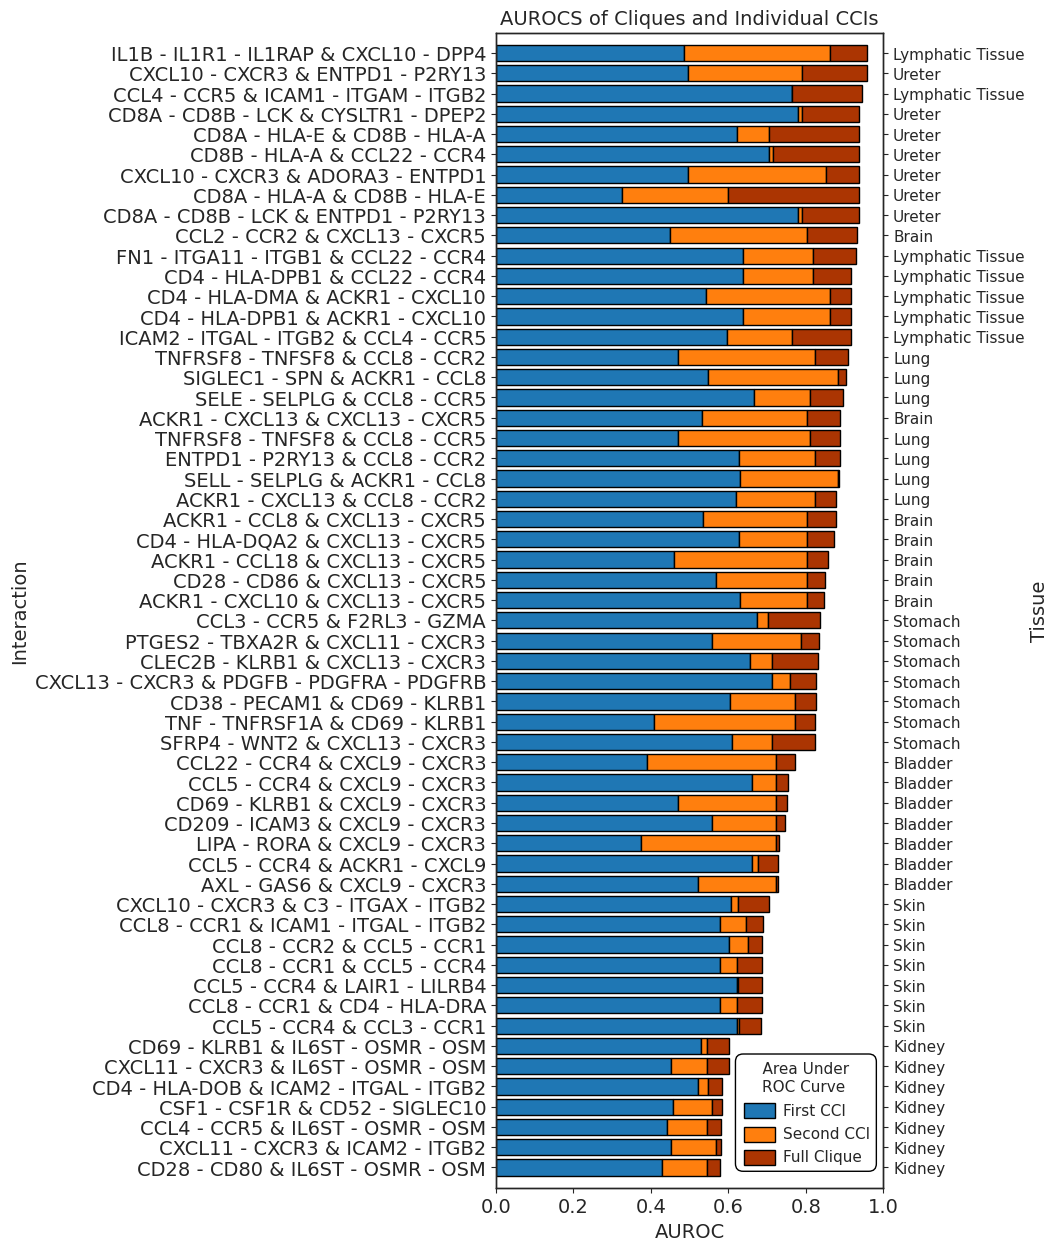

In [164]:
fs = 14
smallfs = 11

fig, ax = plt.subplots(1, 1, figsize=(5, 15))

# Sort and prepare data
barplotdf = barplotdf.sort_values(by='auroc', ascending=True)
y_pos = np.arange(len(barplotdf))

height = 0.8

# Plotting the bar segments
for j, (i, row) in enumerate(barplotdf.iterrows()):
    ypos = y_pos[j]

    auroc1 = row['auroc1']
    auroc2 = row['auroc2']
    auroc = row['auroc']

    # First segment
    if auroc1 != 0:
        ax.barh(ypos, auroc1, color='C0', height=height, edgecolor='k', linewidth=1)

    left2 = auroc1
    width2 = auroc2 - auroc1
    ax.barh(ypos, width2, left=left2, color='C1', height=height, edgecolor='k', linewidth=1)

    # Third segment
    width3 = auroc - auroc2
    if width3 != 0:
        ax.barh(ypos, width3, left=auroc2, color=tcolor, height=height, edgecolor='k', linewidth=1)

# Main Y-axis (interaction labels)
ax.set_yticks(y_pos)
ax.set_yticklabels(barplotdf['interaction'], fontsize=fs)
ax.invert_yaxis()
ax.set_xlabel('AUROC', fontsize=fs)
ax.set_ylabel('Interaction', fontsize=fs)
ax.set_ylim(-1, len(barplotdf))
ax.tick_params(axis='x', labelsize=fs)
ax.set_xlim(0, 1)

# Twin Y-axis for tissue labels
ax_twin = ax.twinx()
ax_twin.set_yticks(y_pos)
ax_twin.set_yticklabels(barplotdf['tissue'], fontsize=smallfs)
ax_twin.invert_yaxis()
ax_twin.set_ylim(-1, len(barplotdf))
ax_twin.tick_params(axis='y', labelsize=smallfs)
ax_twin.set_ylabel('Tissue', fontsize=fs)


## Horizontal line to separate negative/positive
#N_neg = sum(barplotdf['log2_hr'] < 0)
#ax.axhline(N_neg - 0.5, color='black', linewidth=2, linestyle='-')
#
## Color y-axis labels
#y_labels = ax.get_yticklabels()
#for i, label in enumerate(y_labels):
#    label.set_color(ncolor if i < N_neg else tcolor)
#
## Symmetric x-axis limits
#xlim1, xlim2 = ax.get_xlim()
#xlim = max(np.abs(xlim1), np.abs(xlim2))
##ax.set_xlim(-xlim, xlim)

# Plot title
ax.set_title('AUROCS of Cliques and Individual CCIs', fontsize=fs)

# Labels
props = dict(boxstyle='round,pad=0.5', facecolor='none', edgecolor='black', linewidth=1)
ax.text(0.8, 0.065, '    Area Under    \nROC Curve \n\n\n\n', ha='center', va='center', fontsize=smallfs, transform=ax.transAxes, bbox=props)

# Legend for high expression box
legend_x, legend_y = 0.64, 0.06
width, height = 0.08, 0.013
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C0', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'First CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)

legend_y -= 0.02
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor='C1', edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Second CCI', transform=ax.transAxes,
        va='center', fontsize=smallfs)

legend_y -= 0.02
color = tcolor  # or ncolor if you want to differentiate
ax.add_patch(patches.Rectangle((legend_x, legend_y), width, height, transform=ax.transAxes,
                               facecolor=color, edgecolor='k'))
ax.text(legend_x + width + 0.02, legend_y + height/2, 'Full Clique', transform=ax.transAxes,
        va='center', fontsize=smallfs)

ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/auroc_barplot.pdf', bbox_inches='tight', dpi=300)
plt.savefig('/home/lnemati/pathway_crosstalk/results/figures/immunotherapy/auroc_barplot.png', bbox_inches='tight', dpi=300)

plt.show()


In [20]:
full_dataset = pd.read_csv('/home/lnemati/pathway_crosstalk/data/immunotherapy/cohorts/full_dataset.csv')

In [23]:
full_dataset['response_NR'].value_counts()

response_NR
N    888
R    358
Name: count, dtype: int64

In [24]:
888 / 1246

0.7126805778491172

In [18]:
len(genes_subset)

56270